# Visual - Facial Keypoints & Gaze Direction

Symbol convention: 
- N: batch size
- T: number of samples per batch (each sample includes _v_ key points)
- V: number of key point per person
- M: number of person 
- C: information per point, like (x,y,z)-Coordinate or (x,y,z,p)-Coordinate + Confident probability  

Step:
- load the data and reshape it and return 2 things 'coordinate (T x V x C)' and 'final (T x V x C+1)'
- cut the samples with 2 cases: 
  - Only the start and the end to match the start/end time in the Transcript (Interview might start later and end earlier)
  - Cut all others besides Participant based on the start/end time in the Transcript
- apply sliding windows technique (Window Size: 30s, Overlapping: 10s)
- store the data as numpy format (.npy)


What to create:
```
[original_sample]
 ├── [visual-keypoints]
 │    ├── [coordinate]
 │    └── [coordinate+confidence]
 ├── [visual-gaze]
 │    ├── [coordinate]
 │    └── [coordinate+confidence]
 │
[clipped_sample]
 ├── [visual-keypoints]
 │    ├── [coordinate]
 │    └── [coordinate+confidence]
 └── [visual-gaze]
      ├── [coordinate]
      └── [coordinate+confidence]
```

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
# import seaborn as sns

%matplotlib inline

In [84]:
participant = "363_P"
fkps_3D_name = "363_CLNF_features3D.txt"
gaze_3D_name = "363_CLNF_gaze.txt"
transcipt = "363_TRANSCRIPT.csv"

## load the data and reshape
return 2 things 'coordinate (T x V x C)' and 'final (T x V x C+1)'

In [85]:
'''
The gaze is output as 4 vectors (relative to the origin of each coordinate):
    
       right eye        left eye          right eye           left eye
    [x_0, y_0, z_0], [x_1, y_1, z_1], [x_h0, y_h0, z_h0], [x_h1, y_h1, z_h1]
    
The first two vectors are in world coordinate space describing the gaze direction of both 
eyes, the second two vectors describe the gaze in head coordinate space (so if the eyes 
are rolled up, the vectors will indicate up even if the head is turned or tilted)
'''

gaze_3D = pd.read_csv(os.path.join(participant, gaze_3D_name))
gaze_3D

frame    timestamp   confidence   success       x_0       y_0  \
0          1     0.000000     0.976789         1  0.087641  0.329975   
1          2     0.033333     0.975876         1  0.078196  0.335327   
2          3     0.066667     0.976059         1  0.081275  0.335034   
3          4     0.100000     0.976020         1  0.082534  0.334744   
4          5     0.133333     0.976018         1  0.084290  0.334016   
...      ...          ...          ...       ...       ...       ...   
36809  36810  1226.970000     0.979590         1  0.045677  0.313117   
36810  36811  1227.000000     0.978680         1  0.050493  0.308164   
36811  36812  1227.030000     0.978359         1  0.025513  0.307093   
36812  36813  1227.070000     0.976940         1  0.032150  0.301908   
36813  36814  1227.100000     0.977877         1  0.046086  0.301381   

            z_0       x_1       y_1       z_1      x_h0      y_h0      z_h0  \
0     -0.939912 -0.225797  0.395038 -0.890483  0.240443  0.473796 -0.847174   
1     -0.938851 -0.220989  0.400877 -0.889079  0.227571  0.486322 -0.843625   
2     -0.938694 -0.217276  0.400865 -0.889999  0.230877  0.488632 -0.841388   
3     -0.938688 -0.217109  0.402333 -0.889377  0.231092  0.487760 -0.841835   
4     -0.938791 -0.216260  0.402638 -0.889446  0.231793  0.485601 -0.842890   
...         ...       ...       ...       ...       ...       ...       ...   
36809 -0.948615 -0.232665  0.295319 -0.926636  0.189638  0.490509 -0.850552   
36810 -0.949992 -0.216563  0.303334 -0.927949  0.194896  0.485106 -0.852460   
36811 -0.951337 -0.220023  0.304916 -0.926616  0.171956  0.483236 -0.858437   
36812 -0.952795 -0.240827  0.296691 -0.924109  0.179782  0.475128 -0.861355   
36813 -0.952389 -0.213901  0.293952 -0.931579  0.195178  0.473392 -0.858956   

           x_h1      y_h1      z_h1  
0     -0.064196  0.578477 -0.813168  
1     -0.062027  0.590675 -0.804522  
2     -0.057630  0.593918 -0.802459  
3     -0.058036  0.595267 -0.801429  
4     -0.057954  0.594465 -0.802030  
...         ...       ...       ...  
36809 -0.089770  0.499770 -0.861494  
36810 -0.072213  0.505839 -0.859600  
36811 -0.073975  0.503631 -0.860746  
36812 -0.094029  0.494817 -0.863895  
36813 -0.064969  0.490984 -0.868743  

[36814 rows x 16 columns]

In [4]:
gaze_conf = gaze_3D[' confidence'].to_numpy()
gaze_coor = gaze_3D.iloc[:, 4:].to_numpy().reshape(len(gaze_3D), 4, 3)  # 4 gaze vectors, 3 axes
T, V, C = gaze_coor.shape

# initialize the final gaze_3D which contains coordinate and confidence score
gaze_final = np.zeros((T, V, C+1))

gaze_final[:, :, :3] = gaze_coor
for i in range(V):
    gaze_final[:, i, 3] = gaze_conf

# return 2 things -> gaze_coor, gaze_final
print('Output shape: number of sample x number of point x value(coordinate / confidence score)')
print('Output 1 - Gaze Coordinate, shape: {}'.format(gaze_coor.shape))
print('Output 2 - Gaze Coordinate + Confidence Score, shape: {}'.format(gaze_final.shape))

Output shape: number of sample x number of point x value(coordinate / confidence score)
Output 1 - Gaze Coordinate, shape: (24658, 4, 3)
Output 2 - Gaze Coordinate + Confidence Score, shape: (24658, 4, 4)


In [5]:
# read the 3D facial keypoints text file by using pd.read_csv 
fkps_3D = pd.read_csv(os.path.join(participant, fkps_3D_name))
fkps_3D

frame   timestamp   confidence   success       X0       X1       X2  \
0          1    0.000000     0.936757         1 -132.181 -132.381 -131.237   
1          2    0.033333     0.936779         1 -132.146 -132.387 -131.238   
2          3    0.066667     0.933320         1 -131.440 -131.829 -130.882   
3          4    0.100000     0.933270         1 -131.196 -131.627 -130.738   
4          5    0.133333     0.933195         1 -131.156 -131.592 -130.714   
...      ...         ...          ...       ...      ...      ...      ...   
24653  24654  821.767000     0.919660         1 -107.298 -107.187 -104.676   
24654  24655  821.800000     0.923476         1 -109.156 -109.016 -106.394   
24655  24656  821.833000     0.924954         1 -110.734 -110.642 -108.030   
24656  24657  821.867000     0.928383         1 -112.090 -112.186 -109.785   
24657  24658  821.900000     0.934417         1 -114.414 -114.675 -112.390   

             X3        X4        X5  ...      Z58      Z59      Z60      Z61  \
0     -128.4720 -121.7120 -108.9770  ...  489.161  495.441  506.195  493.874   
1     -128.4050 -121.5300 -108.7160  ...  489.407  495.507  506.052  493.925   
2     -128.2900 -121.6890 -109.0330  ...  490.461  496.481  506.881  494.890   
3     -128.2320 -121.7270 -109.1300  ...  490.386  496.431  506.825  494.833   
4     -128.2230 -121.7410 -109.1630  ...  490.515  496.583  506.984  494.963   
...         ...       ...       ...  ...      ...      ...      ...      ...   
24653  -99.2634  -90.8950  -79.4205  ...  485.028  489.667  495.825  483.679   
24654 -100.7950  -92.1960  -80.6029  ...  483.757  488.798  495.458  482.808   
24655 -102.3910  -93.7468  -82.1666  ...  482.208  487.428  494.344  481.549   
24656 -104.2780  -95.7556  -84.3124  ...  481.478  486.718  493.736  480.804   
24657 -106.9510  -98.4745  -87.0953  ...  481.697  487.077  494.172  481.155   

           Z62      Z63      Z64      Z65      Z66      Z67  
0      493.325  494.404  506.995  492.425  490.959  492.044  
1      493.373  494.468  506.844  492.636  491.174  492.226  
2      494.311  495.380  507.626  493.679  492.242  493.291  
3      494.239  495.292  507.536  493.591  492.174  493.239  
4      494.366  495.419  507.691  493.720  492.302  493.371  
...        ...      ...      ...      ...      ...      ...  
24653  480.798  478.329  484.532  478.286  480.184  483.177  
24654  479.865  477.362  483.260  477.194  479.111  482.210  
24655  478.526  476.006  481.867  475.573  477.505  480.682  
24656  477.713  475.132  480.969  474.807  476.809  480.053  
24657  477.937  475.282  480.798  474.862  476.960  480.321  

[24658 rows x 208 columns]

In [6]:
# all together
def normalize(data):
    '''recale the data, which is a 2D matrix, to 0-1'''
    return (data - data.min())/(data.max() - data.min())

In [7]:
fkps_conf = fkps_3D[' confidence'].to_numpy()

x_coor = normalize(fkps_3D[fkps_3D.columns[4: 72]].to_numpy())
y_coor = normalize(fkps_3D[fkps_3D.columns[72: 140]].to_numpy())
z_coor = normalize(fkps_3D[fkps_3D.columns[140: 208]].to_numpy())
fkps_coor = np.stack([x_coor, y_coor, z_coor], axis=-1)
T, V, C = fkps_coor.shape

# initialize the final facial key points which contains coordinate and confidence score
fkps_final = np.zeros((T, V, C+1))

fkps_final[:, :, :3] = fkps_coor
for i in range(V):
    fkps_final[:, i, 3] = fkps_conf

# return 2 things -> fkps_coor, fkps_final
print('Output shape: number of sample x number of point x value(coordinate / confidence score)')
print('Output 1 - Facial Keypoints Coordinate, shape: {}'.format(fkps_coor.shape))
print('Output 2 - Facial Keypoints Coordinate + Confidence Score, shape: {}'.format(fkps_final.shape))


Output shape: number of sample x number of point x value(coordinate / confidence score)
Output 1 - Facial Keypoints Coordinate, shape: (24658, 68, 3)
Output 2 - Facial Keypoints Coordinate + Confidence Score, shape: (24658, 68, 4)


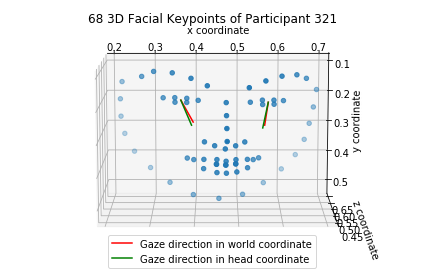

In [8]:
# Visualization
frame = 1000
gaze_length = 0.10

# get the first frame of facial keypoints
x_3D = fkps_coor[frame, :, 0]
y_3D = fkps_coor[frame, :, 1]
z_3D = fkps_coor[frame, :, 2]

# get the gazing vector in world coordinate of each eye
gaze_w_r = gaze_coor[frame, 0, :]
gaze_w_l = gaze_coor[frame, 1, :]
gaze_h_r = gaze_coor[frame, 2, :]
gaze_h_l = gaze_coor[frame, 3, :]

# calculate the middle point of each eye
right_eye_x = (x_3D[37] + x_3D[38] + x_3D[40] + x_3D[41])/4
right_eye_y = (y_3D[37] + y_3D[38] + y_3D[40] + y_3D[41])/4
right_eye_z = (z_3D[37] + z_3D[38] + z_3D[40] + z_3D[41])/4
left_eye_x = (x_3D[43] + x_3D[44] + x_3D[46] + x_3D[47])/4
left_eye_y = (y_3D[43] + y_3D[44] + y_3D[46] + y_3D[47])/4
left_eye_z = (z_3D[43] + z_3D[44] + z_3D[46] + z_3D[47])/4

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_3D,y_3D,z_3D)

ax.plot([right_eye_x, right_eye_x+gaze_w_r[0]*gaze_length], 
        [right_eye_y, right_eye_y+gaze_w_r[1]*gaze_length], 
        [right_eye_z, right_eye_z+gaze_w_r[2]*gaze_length], 'r-', label='Gaze direction in world coordinate')
ax.plot([left_eye_x, left_eye_x+gaze_w_l[0]*gaze_length], 
        [left_eye_y, left_eye_y+gaze_w_l[1]*gaze_length], 
        [left_eye_z, left_eye_z+gaze_w_l[2]*gaze_length], 'r-')

ax.plot([right_eye_x, right_eye_x+gaze_h_r[0]*gaze_length], 
        [right_eye_y, right_eye_y+gaze_h_r[1]*gaze_length],
        [right_eye_z, right_eye_z+gaze_h_r[2]*gaze_length], 'g-',  label='Gaze direction in head coordinate')
ax.plot([left_eye_x, left_eye_x+gaze_h_l[0]*gaze_length], 
        [left_eye_y, left_eye_y+gaze_h_l[1]*gaze_length], 
        [left_eye_z, left_eye_z+gaze_h_l[2]*gaze_length], 'g-')

ax.view_init(elev = -80, azim = -90)
ax.set_title('68 3D Facial Keypoints of Participant 321')
ax.legend(loc = 'lower center')
ax.set_xlabel("x coordinate") 
ax.set_ylabel("y coordinate")
ax.set_zlabel("z coordinate")

plt.tight_layout()
# # save images
# fig.savefig(os.path.join('temp', "frame_{}.png".format(frame)))
# plt.close()
plt.show()

# Filter Key Points

Only the following KP will be kept:
- KP Num: 
  
  [ 1, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 52, 53, 56, 57, 58, 59, 60, 66, 67, 68]


In [47]:
KP_ID = np.array([ 1, 17, 18, 19, 20, 21, 22, 23, 24, 25, 
                  26, 27, 28, 29, 30, 31, 37, 38, 39, 40,
                  41, 42, 43, 44, 45, 46, 47, 48, 51, 52,
                  53, 56, 57, 58, 59, 60, 66, 67, 68])
print(len(KP_ID))
KP_ID

39


array([ 1, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 52, 53, 56, 57, 58,
       59, 60, 66, 67, 68])

In [49]:
KP_ID = np.array([ 1, 17, 18, 19, 20, 21, 22, 23, 24, 25, 
                  26, 27, 28, 29, 30, 31, 37, 38, 39, 40,
                  41, 42, 43, 44, 45, 46, 47, 48, 51, 52,
                  53, 56, 57, 58, 59, 60, 66, 67, 68])

filtered_fkps_coor = fkps_coor[:, np.sort(KP_ID-1)]
filtered_fkps_coor.shape

(24658, 39, 3)

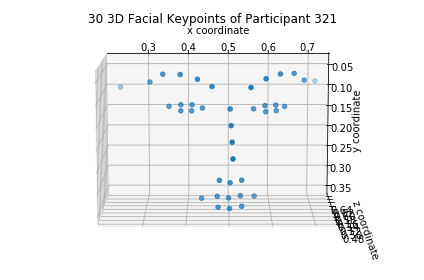

In [52]:
# Visualization
frame = 250

# get the first frame of facial keypoints
x_3D = filtered_fkps_coor[frame, :, 0]
y_3D = filtered_fkps_coor[frame, :, 1]
z_3D = filtered_fkps_coor[frame, :, 2]

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_3D,y_3D,z_3D)

ax.view_init(elev = -80, azim = -90)
ax.set_title('30 3D Facial Keypoints of Participant 321')
ax.set_xlabel("x coordinate") 
ax.set_ylabel("y coordinate")
ax.set_zlabel("z coordinate")

plt.tight_layout()
# # save images
# fig.savefig(os.path.join('temp', "frame_{}.png".format(frame)))
# plt.close()
plt.show()

In [ ]:
neighbor_link = [(0, 2), (0, 16), (1, 11), (1, 25), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7),
                 (7, 8), (8, 9), (9, 10), (10, 11), (12, 13), (13, 14), (14, 15), (16, 17),
                 (17, 18), (18, 19), (19, 20), (20, 21), (21, 16), (22, 23), (23, 24), 
                 (24, 25), (25, 26), (26, 27), (22, 27), (28, 29), (29, 30), (31, 32), 
                 (32, 33), (33, 34), (34, 35), (36, 37), (37, 38)]

## Cut the samples with 2 cases:

### - Only the start and the end to match the start/end time in the Transcript 
(Interview might start later and end earlier)


function input
- data (fkps_coor)
- transcipt
- sr, in Hz
- window_size, in s
- overlap_size, in s
- padding, boolean

In [111]:
participant = "321_P"
fkps_3D_name = "321_CLNF_features3D.txt"
gaze_3D_name = "321_CLNF_gaze.txt"
transcipt = "321_TRANSCRIPT.csv"

transcript = pd.read_csv(os.path.join(participant, transcipt), sep='\t').fillna('')
# transcript.head(5)

# initialization
visual_sr = 30     # 30Hz
window_size = 60   # 30s
overlap_size = 10  # 10s
clipping = False
padding = True

### - Cut all others besides Participant based on the start/end time in the Transcript

# Audio - Raw Waveform & spectrogram

In [40]:
import os
import numpy as np
import pandas as pd
import wave
import librosa
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import soundfile as sf

%matplotlib inline

In [45]:
root_dir = 'C:/Users/denni/Documents/KIT Studium/Bachelorarbeit/DAIC-WOZ Dataset/'
number = 321
participant = "{}_P".format(number)
audio_file = '{}_AUDIO.wav'.format(number)
transcipt_file = "{}_TRANSCRIPT.csv".format(number)

wavefile = wave.open(os.path.join(root_dir, participant, audio_file))
audio_sr = wavefile.getframerate()
n_samples = wavefile.getnframes()
signal = np.frombuffer(wavefile.readframes(n_samples), dtype=np.short)
T = signal.shape[0]

transcript = pd.read_csv(os.path.join(root_dir, participant, transcipt_file), sep='\t').fillna('')
first_start_time = transcript['start_time'][0]
last_stop_time = transcript['stop_time'][len(transcript)-1]

## Original signal

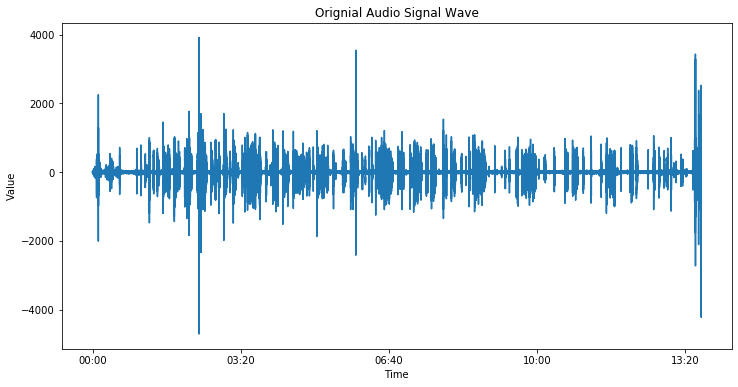

In [46]:
# original signal

Time = np.linspace(0, T/audio_sr, num=T) # in s

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Time, signal)

def x_fmt(x, y):
    minute = int(x // 60)
    second = int(x % 60)
    return f'{minute:02}:{second:02}'

ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("Orignial Audio Signal Wave")
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))

plt.show()

## Filtered and zero-padded Audio Signal

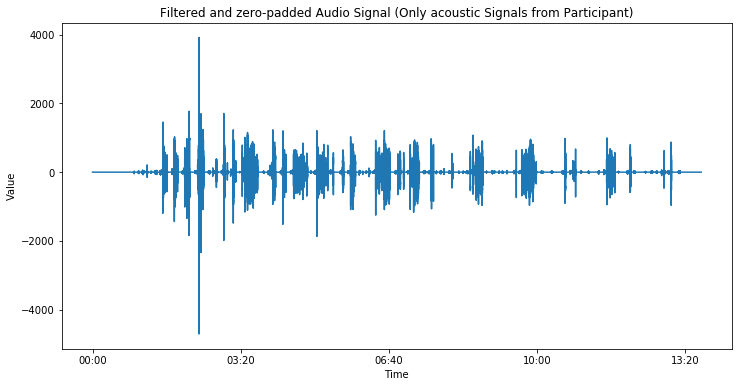

In [36]:
# Filtered and zero-padded Audio Signal and cut start and end (Only acoustic Signals from Participant)

filtered_signal = np.zeros(signal.shape[0])

# filtering
for t in transcript.itertuples():
    if getattr(t,'speaker') == 'Participant':
        start = getattr(t,'start_time')
        stop = getattr(t,'stop_time')
        
        filtered_signal[int(start*audio_sr):int(stop*audio_sr)] = signal[int(start*audio_sr):int(stop*audio_sr)]

# cut start and end
filtered_signal = filtered_signal[int(first_start_time*audio_sr):int(last_stop_time*audio_sr)] 

# plot
Time = np.linspace(0, filtered_signal.shape[0]/audio_sr, num=filtered_signal.shape[0]) # in s

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Time, filtered_signal)

def x_fmt(x, y):
    minute = int(x // 60)
    second = int(x % 60)
    return f'{minute:02}:{second:02}'

ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("Filtered and zero-padded Audio Signal (Only acoustic Signals from Participant)")
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))

plt.show()

In [37]:
sf.write("filtered_signal.wav", filtered_signal, audio_sr)

## Clipped Audio Signal

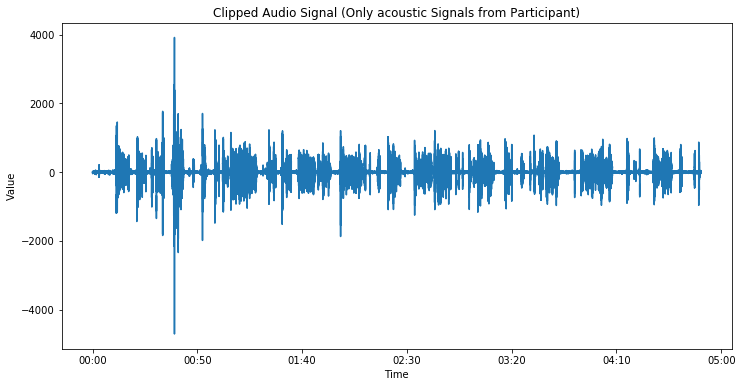

In [5]:
# filter out others besides participant and clipped

clipped_signal = []

for t in transcript.itertuples():
    if getattr(t,'speaker') == 'Participant':
        start = getattr(t,'start_time')
        stop = getattr(t,'stop_time')
        
        clipped_signal = np.hstack((clipped_signal, signal[int(start*audio_sr):int(stop*audio_sr)])) 

# plot
Time = np.linspace(0, clipped_signal.shape[0]/audio_sr, num=clipped_signal.shape[0]) # in s

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Time, clipped_signal)

def x_fmt(x, y):
    minute = int(x // 60)
    second = int(x % 60)
    return f'{minute:02}:{second:02}'

ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("Clipped Audio Signal (Only acoustic Signals from Participant)")
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))

plt.show()

In [103]:
# sf.write("clipped_signal.wav", clipped_signal, audio_sr)

## Augmentation: add white noise, random gain, invert polarity

In [33]:
# add white noise

def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal


# '''
# Code from: https://github.com/sleekEagle/audio_processing
# '''
# #SNR in dB
# #given a signal and desired SNR, this gives the required AWGN what should be added to the signal to get the desired SNR
# def add_white_noise(signal, SNR) :
#     #RMS value of signal
#     RMS_s=np.sqrt(np.mean(signal**2))
#     #RMS values of noise
#     RMS_n=np.sqrt(RMS_s**2/(pow(10,SNR/10)))
#     #Additive white gausian noise. Thereore mean=0
#     #Because sample length is large (typically > 40000)
#     #we can use the population formula for standard daviation.
#     #because mean=0 STD=RMS
#     STD_n=RMS_n
#     noise=np.random.normal(0, STD_n, signal.shape[0])
#     return signal + noise

#given a signal, noise (audio) and desired SNR, this gives the noise (scaled version of noise input) that gives the desired SNR
def add_noise_from_sound(signal, noise, SNR):
    RMS_s=np.sqrt(np.mean(signal**2))
    #required RMS of noise
    RMS_n=np.sqrt(RMS_s**2/(pow(10,SNR/10)))
    
    #current RMS of noise
    RMS_n_current=np.sqrt(np.mean(noise**2))
    noise=noise*(RMS_n/RMS_n_current)
    
    return signal + noise


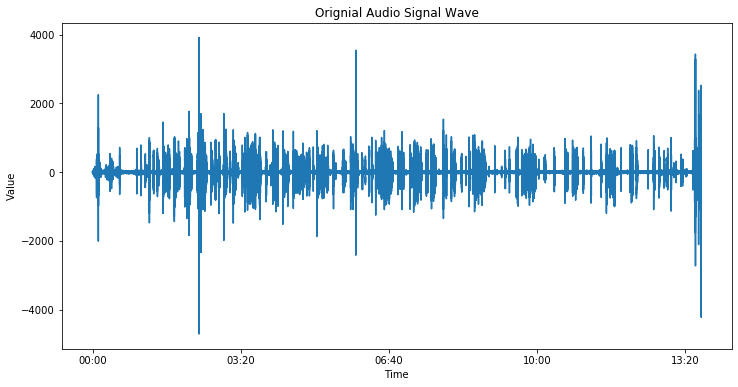

In [35]:
augmented_signal = add_white_noise(signal.astype(float), 1e-10)

Time = np.linspace(0, T/audio_sr, num=T) # in s

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Time, augmented_signal)

def x_fmt(x, y):
    minute = int(x // 60)
    second = int(x % 60)
    return f'{minute:02}:{second:02}'

ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("Orignial Audio Signal Wave")
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))

plt.show()

sf.write("321_noise.wav", augmented_signal, audio_sr)

In [25]:
participant = "426_P"
transcipt = "426_TRANSCRIPT.csv"

In [29]:
transcript = pd.read_csv(os.path.join(participant, transcipt), sep='\t').fillna('')
transcript.head(5)

start_time  stop_time      speaker  \
0      14.360     15.310  Participant   
1      34.517     56.057        Ellie   
2      56.240     56.720  Participant   
3      57.156     57.616        Ellie   
4      58.722     60.992        Ellie   

                                               value  
0                                             <sync.  
1  IntroV4Confirmation (hi i'm ellie thanks for c...  
2                                                yes  
3                                okay_confirm (okay)  
4            how_doingV (so how are you doing today)

In [28]:
transcript = pd.read_csv(os.path.join(participant, transcipt), sep='\t').fillna('')

for t in transcript.itertuples():
    if getattr(t,'speaker') == 'Participant':
        if 'scrubbed_entry' in getattr(t,'value'):
            continue

In [266]:
'INPUT_FEATURE_DIM'.lower()

'input_feature_dim'

In [238]:
fkps_coor = np.load('temp/303-03_kps.npy')
gaze_coor = np.load('temp/303-03_gaze.npy')

In [248]:
gaze_coor.shape
fkps_coor.shape

(1800, 68, 4)

In [253]:
visual = np.concatenate((fkps_coor, gaze_coor), axis=1)

visual.shape

(1800, 72, 4)

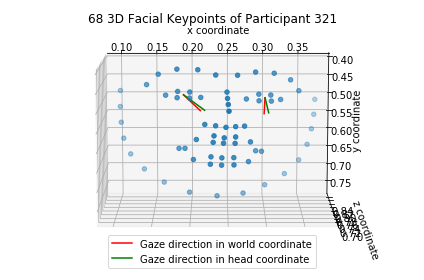

In [242]:
# Visualization
frame = 1000
gaze_length = 0.10

# get the first frame of facial keypoints
x_3D = fkps_coor[frame, :, 0]
y_3D = fkps_coor[frame, :, 1]
z_3D = fkps_coor[frame, :, 2]

# get the gazing vector in world coordinate of each eye
gaze_w_r = gaze_coor[frame, 0, :]
gaze_w_l = gaze_coor[frame, 1, :]
gaze_h_r = gaze_coor[frame, 2, :]
gaze_h_l = gaze_coor[frame, 3, :]

# calculate the middle point of each eye
right_eye_x = (x_3D[37] + x_3D[38] + x_3D[40] + x_3D[41])/4
right_eye_y = (y_3D[37] + y_3D[38] + y_3D[40] + y_3D[41])/4
right_eye_z = (z_3D[37] + z_3D[38] + z_3D[40] + z_3D[41])/4
left_eye_x = (x_3D[43] + x_3D[44] + x_3D[46] + x_3D[47])/4
left_eye_y = (y_3D[43] + y_3D[44] + y_3D[46] + y_3D[47])/4
left_eye_z = (z_3D[43] + z_3D[44] + z_3D[46] + z_3D[47])/4

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_3D,y_3D,z_3D)

ax.plot([right_eye_x, right_eye_x+gaze_w_r[0]*gaze_length], 
        [right_eye_y, right_eye_y+gaze_w_r[1]*gaze_length], 
        [right_eye_z, right_eye_z+gaze_w_r[2]*gaze_length], 'r-', label='Gaze direction in world coordinate')
ax.plot([left_eye_x, left_eye_x+gaze_w_l[0]*gaze_length], 
        [left_eye_y, left_eye_y+gaze_w_l[1]*gaze_length], 
        [left_eye_z, left_eye_z+gaze_w_l[2]*gaze_length], 'r-')

ax.plot([right_eye_x, right_eye_x+gaze_h_r[0]*gaze_length], 
        [right_eye_y, right_eye_y+gaze_h_r[1]*gaze_length],
        [right_eye_z, right_eye_z+gaze_h_r[2]*gaze_length], 'g-',  label='Gaze direction in head coordinate')
ax.plot([left_eye_x, left_eye_x+gaze_h_l[0]*gaze_length], 
        [left_eye_y, left_eye_y+gaze_h_l[1]*gaze_length], 
        [left_eye_z, left_eye_z+gaze_h_l[2]*gaze_length], 'g-')

ax.view_init(elev = -80, azim = -90)
ax.set_title('68 3D Facial Keypoints of Participant 321')
ax.legend(loc = 'lower center')
ax.set_xlabel("x coordinate") 
ax.set_ylabel("y coordinate")
ax.set_zlabel("z coordinate")

plt.tight_layout()
# # save images
# fig.savefig(os.path.join('temp', "frame_{}.png".format(frame)))
# plt.close()
plt.show()

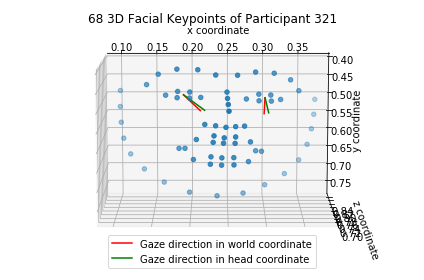

In [255]:
# Visualization
frame = 1000
gaze_length = 0.10

# get the first frame of facial keypoints
x_3D = visual[frame, :68, 0]
y_3D = visual[frame, :68, 1]
z_3D = visual[frame, :68, 2]

# get the gazing vector in world coordinate of each eye
gaze_w_r = visual[frame, 68, :]
gaze_w_l = visual[frame, 69, :]
gaze_h_r = visual[frame, 70, :]
gaze_h_l = visual[frame, 71, :]

# calculate the middle point of each eye
right_eye_x = (x_3D[37] + x_3D[38] + x_3D[40] + x_3D[41])/4
right_eye_y = (y_3D[37] + y_3D[38] + y_3D[40] + y_3D[41])/4
right_eye_z = (z_3D[37] + z_3D[38] + z_3D[40] + z_3D[41])/4
left_eye_x = (x_3D[43] + x_3D[44] + x_3D[46] + x_3D[47])/4
left_eye_y = (y_3D[43] + y_3D[44] + y_3D[46] + y_3D[47])/4
left_eye_z = (z_3D[43] + z_3D[44] + z_3D[46] + z_3D[47])/4

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_3D,y_3D,z_3D)

ax.plot([right_eye_x, right_eye_x+gaze_w_r[0]*gaze_length], 
        [right_eye_y, right_eye_y+gaze_w_r[1]*gaze_length], 
        [right_eye_z, right_eye_z+gaze_w_r[2]*gaze_length], 'r-', label='Gaze direction in world coordinate')
ax.plot([left_eye_x, left_eye_x+gaze_w_l[0]*gaze_length], 
        [left_eye_y, left_eye_y+gaze_w_l[1]*gaze_length], 
        [left_eye_z, left_eye_z+gaze_w_l[2]*gaze_length], 'r-')

ax.plot([right_eye_x, right_eye_x+gaze_h_r[0]*gaze_length], 
        [right_eye_y, right_eye_y+gaze_h_r[1]*gaze_length],
        [right_eye_z, right_eye_z+gaze_h_r[2]*gaze_length], 'g-',  label='Gaze direction in head coordinate')
ax.plot([left_eye_x, left_eye_x+gaze_h_l[0]*gaze_length], 
        [left_eye_y, left_eye_y+gaze_h_l[1]*gaze_length], 
        [left_eye_z, left_eye_z+gaze_h_l[2]*gaze_length], 'g-')

ax.view_init(elev = -80, azim = -90)
ax.set_title('68 3D Facial Keypoints of Participant 321')
ax.legend(loc = 'lower center')
ax.set_xlabel("x coordinate") 
ax.set_ylabel("y coordinate")
ax.set_zlabel("z coordinate")

plt.tight_layout()
# # save images
# fig.savefig(os.path.join('temp', "frame_{}.png".format(frame)))
# plt.close()
plt.show()

In [225]:
import torch.nn as nn
from scipy import stats
import torch.nn.functional as F

In [221]:
# def convert_soft_gt(gt, evaluator_config):

#     if evaluator_config['PREDICT_TYPE'] == 'phq-subscores':
#         # gt: 1D array with shape 1 x num_subscores
#         # Each subscore choose a score from [0, 1, 2, 3], we normalize it into 0 ~ config['CLASSES_RESOLUTION']
#         factor = (evaluator_config['N_CLASSES'] - 1) / (evaluator_config['CLASSES_RESOLUTION'] - 1)
#         tmp = [stats.norm.pdf(np.arange(evaluator_config['CLASSES_RESOLUTION']), loc=score / factor,
#                               scale=evaluator_config['STD']).astype(np.float32) for score in gt]
        
#         tmp = np.stack(tmp)  # shape: (num_subscores, class_resolution)
        
#     else:
#         # gt: a float value
#         factor = (evaluator_config['N_CLASSES'] - 1) / (evaluator_config['CLASSES_RESOLUTION'] - 1)
#         tmp = stats.norm.pdf(np.arange(evaluator_config['CLASSES_RESOLUTION']), loc=gt / factor,
#                              scale=evaluator_config['STD']).astype(np.float32) # shape: (class_resolution, )
        
#     return torch.from_numpy(tmp / tmp.sum(axis=-1, keepdims=True))


# def get_soft_gt(gt, evaluator_config):

#     soft_gt = torch.tensor([[]])

#     # iterate through each batch 
#     for i in range(len(gt)):
#         current_gt = gt[i]
#         converted_current_gt = convert_soft_gt(current_gt, evaluator_config)
#         if i == 0:
#             soft_gt = converted_current_gt
#         else:
#             soft_gt = torch.stack([soft_gt, converted_current_gt], dim=0)

#     return soft_gt  # shape (batch, class_resolution) or (batch, num_subscores, class_resolution)


# def compute_loss(criterion, probs, gt, evaluator_config, use_soft_label=False):

#     if use_soft_label:  # in this case, criterion should be nn.KLDivLoss()
        
#         # convert GT to soft label
#         soft_gt = get_soft_gt(gt, evaluator_config)

#         if evaluator_config['PREDICT_TYPE'] == 'phq-subscores':
#             loss = sum([criterion(torch.log(probs[i]), soft_gt[:, i])
#                         for i in range(evaluator_config['N_SUBSCORES'])])
#         else:
            
#             loss = criterion(torch.log(probs), soft_gt)

#     else:  # in this case, criterion should be  nn.CrossEntropyLoss() with weights

#         if evaluator_config['PREDICT_TYPE'] == 'phq-subscores':
            
#             assert probs
            
#             # convert to shape (batch size,  number of subscores, class resolution)
#             pred_prob = torch.stack([prob for prob in probs], dim=1)
#             # compute loss: make sure dem-1 of prediction is softmax probabilities
#             loss = criterion(pred_prob.permute(0, 2, 1).contiguous(),
#                              gt.type(torch.LongTensor))
#         else:
#             loss = criterion(probs, gt.type(torch.LongTensor))
            
#     return loss

In [296]:
# def convert_soft_gt(gt, evaluator_config):

#     if evaluator_config['PREDICT_TYPE'] == 'phq-subscores':
#         # gt: 1D array with shape 1 x num_subscores
#         # Each subscore choose a score from [0, 1, 2, 3], we normalize it into 0 ~ config['CLASSES_RESOLUTION']
#         factor = (evaluator_config['N_CLASSES'] - 1) / (evaluator_config['CLASSES_RESOLUTION'] - 1)
#         tmp = [stats.norm.pdf(np.arange(evaluator_config['CLASSES_RESOLUTION']), loc=score / factor,
#                               scale=evaluator_config['STD']).astype(np.float32) for score in gt]

#         tmp = np.stack(tmp)  # shape: (num_subscores, class_resolution)
    
#     else:
#         # gt: a float value
#         factor = (evaluator_config['N_CLASSES'] - 1) / (evaluator_config['CLASSES_RESOLUTION'] - 1)
#         tmp = stats.norm.pdf(np.arange(evaluator_config['CLASSES_RESOLUTION']), loc=gt / factor,
#                              scale=evaluator_config['STD']).astype(np.float32) # shape: (class_resolution, )

#     return torch.from_numpy(tmp / tmp.sum(axis=-1, keepdims=True))


# def get_soft_gt(gt, evaluator_config):

#     soft_gt = torch.tensor([[]])

#     # iterate through each batch 
#     for i in range(len(gt)):
#         current_gt = gt[i]
#         converted_current_gt = convert_soft_gt(current_gt, evaluator_config)
#         if i == 0:
#             soft_gt = converted_current_gt
#         else:
#             soft_gt = torch.stack([soft_gt, converted_current_gt], dim=0)

#     return soft_gt  # shape (batch, class_resolution) or (batch, num_subscores, class_resolution)


# def compute_loss(criterion, probs, gt, evaluator_config, use_soft_label=False):

#     if use_soft_label:  # in this case, criterion should be nn.KLDivLoss()
       
#         # convert GT to soft label
#         soft_gt = get_soft_gt(gt, evaluator_config)

#         if evaluator_config['PREDICT_TYPE'] == 'phq-subscores':
#             loss = sum([criterion(torch.log(probs[i]), soft_gt[:, i])
#                         for i in range(evaluator_config['N_SUBSCORES'])])
#         else:
#             loss = criterion(torch.log(probs), soft_gt)

#     else:  # in this case, criterion should be  nn.CrossEntropyLoss() with weights

#         if evaluator_config['PREDICT_TYPE'] == 'phq-subscores':
#             # convert to shape (batch size,  number of subscores, class resolution)
#             pred_prob = torch.stack([prob for prob in probs], dim=1)
#             # compute loss: make sure dem-1 of prediction is softmax probabilities
#             loss = criterion(pred_prob.permute(0, 2, 1).contiguous(),
#                              gt.type(torch.LongTensor))
#         else:
#             loss = criterion(probs, gt.type(torch.LongTensor))
            
#     return loss


# def get_criterion(criterion_config):

#     if criterion_config['USE_SOFT_LABEL']:

#         criterion = nn.KLDivLoss()

#     else:
#         assert criterion_config['WEIGHTS'] is not None, \
#             "'config['CRITERION']['WEIGHTS']' must be given for utilizing Cross Entropy to improve prediction with imbalance dataset"
        
#         # initialize loss weights based on class imbalance ratio in the dataset
#         weights = torch.tensor(list(criterion_config['WEIGHTS'])).type(torch.FloatTensor)  # [1, 1.558, 4.5, 8.5] [1, 1.4, 3.5, 6]
#         criterion = nn.CrossEntropyLoss(weight=weights)

#     return criterion

In [311]:
evaluator_config = {'PREDICT_TYPE': 'phq-score', 
                    'INPUT_FEATURE_DIM': 768, 
                    'CLASSES_RESOLUTION': 50, 
                    'N_CLASSES': 25,
                    'N_SUBSCORES': 1, 
                    'STD': 5}  # ['phq-subscores', 'phq-score', 'phq-binary']

sub_evaluator_config = {'PREDICT_TYPE': 'phq-subscores', 
                    'INPUT_FEATURE_DIM': 768, 
                    'CLASSES_RESOLUTION': 28, 
                    'N_CLASSES': 4, 
                    'N_SUBSCORES': 8, 
                    'STD': 5}

criterion_config = {'USE_SOFT_LABEL': True,
                    'WEIGHTS': np.random.rand(5)}

# probs = torch.randn(2, 28)

sub_probs = [F.softmax(torch.randn(2, sub_evaluator_config['CLASSES_RESOLUTION']), dim=1) for _ in range(8)]
sub_gt = torch.empty(2, 8, dtype=torch.long).random_(4)

probs = F.softmax(torch.randn(2, evaluator_config['CLASSES_RESOLUTION']), dim=1)
gt = torch.empty(2, dtype=torch.long).random_(evaluator_config['N_CLASSES'])

In [310]:
criterion = get_criterion(criterion_config)
compute_loss(criterion, probs, gt, evaluator_config, use_soft_label=criterion_config['USE_SOFT_LABEL'])

tensor(0.0226)

In [312]:
criterion = get_criterion(criterion_config)
compute_loss(criterion, sub_probs, sub_gt, sub_evaluator_config, use_soft_label=criterion_config['USE_SOFT_LABEL'])

tensor(0.3167)

# hog file

citation: https://gist.github.com/btlorch/6d259bfe6b753a7a88490c0607f07ff8

In [3]:
import numpy as np
import struct


def read_hog(filename, batch_size=5000):
    """
    Read HoG features file created by OpenFace.
    For each frame, OpenFace extracts 12 * 12 * 31 HoG features, i.e., num_features = 4464. These features are stored in row-major order.
    :param filename: path to .hog file created by OpenFace
    :param batch_size: how many rows to read at a time
    :return: is_valid, hog_features
        is_valid: ndarray of shape [num_frames]
        hog_features: ndarray of shape [num_frames, num_features]
    """
    all_feature_vectors = []
    with open(filename, "rb") as f:
        num_cols, = struct.unpack("i", f.read(4))
        num_rows, = struct.unpack("i", f.read(4))
        num_channels, = struct.unpack("i", f.read(4))

        # The first four bytes encode a boolean value whether the frame is valid
        num_features = 1 + num_rows * num_cols * num_channels
        feature_vector = struct.unpack("{}f".format(num_features), f.read(num_features * 4))
        feature_vector = np.array(feature_vector).reshape((1, num_features))
        all_feature_vectors.append(feature_vector)

        # Every frame contains a header of four float values: num_cols, num_rows, num_channels, is_valid
        num_floats_per_feature_vector = 4 + num_rows * num_cols * num_channels
        # Read in batches of given batch_size
        num_floats_to_read = num_floats_per_feature_vector * batch_size
        # Multiply by 4 because of float32
        num_bytes_to_read = num_floats_to_read * 4

        while True:
            bytes = f.read(num_bytes_to_read)
            # For comparison how many bytes were actually read
            num_bytes_read = len(bytes)
            assert num_bytes_read % 4 == 0, "Number of bytes read does not match with float size"
            num_floats_read = num_bytes_read // 4
            assert num_floats_read % num_floats_per_feature_vector == 0, "Number of bytes read does not match with feature vector size"
            num_feature_vectors_read = num_floats_read // num_floats_per_feature_vector

            feature_vectors = struct.unpack("{}f".format(num_floats_read), bytes)
            # Convert to array
            feature_vectors = np.array(feature_vectors).reshape((num_feature_vectors_read, num_floats_per_feature_vector))
            # Discard the first three values in each row (num_cols, num_rows, num_channels)
            feature_vectors = feature_vectors[:, 3:]
            # Append to list of all feature vectors that have been read so far
            all_feature_vectors.append(feature_vectors)

            if num_bytes_read < num_bytes_to_read:
                break

        # Concatenate batches
        all_feature_vectors = np.concatenate(all_feature_vectors, axis=0)

        # Split into is-valid and feature vectors
        is_valid = all_feature_vectors[:, 0]
        feature_vectors = all_feature_vectors[:, 1:]

        return is_valid, feature_vectors

In [81]:
ID = 363
participant = f"{ID}_P"
hog_name = f"{ID}_CLNF_hog.bin"

hog_file = os.path.join(participant, hog_name)

In [82]:
is_valid, feature_vectors = read_hog(hog_file)

In [83]:
feature_vectors.shape

(36814, 4464)

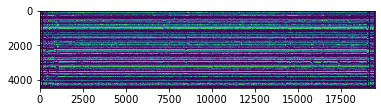

In [49]:
a = 1000
plt.imshow(feature_vectors.transpose(1,0))

In [39]:
np.linalg.norm(feature_vectors[0])

12.366758071017584

# Facial Action Unit Coding System (AUs file)

In [78]:
ID = 363
participant = f"{ID}_P"
AUs_name = f"{ID}_CLNF_AUs.txt"
AUs_file = pd.read_csv(os.path.join(participant, AUs_name))
AUs_file.iloc[:, 4:18]

AU01_r   AU02_r   AU04_r    AU05_r   AU06_r    AU09_r   AU10_r  \
0          0.0      0.0      0.0  0.000000      0.0  0.000000      0.0   
1          0.0      0.0      0.0  0.000000      0.0  0.551621      0.0   
2          0.0      0.0      0.0  0.000000      0.0  0.000000      0.0   
3          0.0      0.0      0.0  0.000000      0.0  0.000000      0.0   
4          0.0      0.0      0.0  0.000000      0.0  0.000000      0.0   
...        ...      ...      ...       ...      ...       ...      ...   
36809      0.0      0.0      0.0  0.932907      0.0  1.561860      0.0   
36810      0.0      0.0      0.0  0.872737      0.0  1.506390      0.0   
36811      0.0      0.0      0.0  0.992034      0.0  1.551250      0.0   
36812      0.0      0.0      0.0  0.870491      0.0  1.299920      0.0   
36813      0.0      0.0      0.0  1.066560      0.0  1.785510      0.0   

        AU12_r    AU14_r    AU15_r    AU17_r    AU20_r   AU25_r   AU26_r  
0      1.08377  0.000000  0.502667  0.707833  0.000000  0.00000      0.0  
1      1.25665  0.548591  0.000000  0.867690  0.000000  0.00000      0.0  
2      1.17866  0.617777  0.518616  0.831962  0.000000  0.00000      0.0  
3      1.20597  0.501757  0.584295  0.763949  0.000000  0.00000      0.0  
4      1.21061  0.000000  0.575086  0.757510  0.000000  0.00000      0.0  
...        ...       ...       ...       ...       ...      ...      ...  
36809  0.00000  0.505222  0.000000  0.000000  0.828793  1.05046      0.0  
36810  0.00000  0.000000  0.000000  0.000000  0.560534  1.27284      0.0  
36811  0.00000  0.000000  0.000000  0.000000  0.000000  0.00000      0.0  
36812  0.00000  0.000000  0.000000  0.000000  0.833565  1.49080      0.0  
36813  0.00000  0.000000  0.000000  0.000000  1.093950  1.67719      0.0  

[36814 rows x 14 columns]

In [75]:
a = AUs_file[' AU01_r'].values
a[np.where(a>0)]

array([0.631335, 0.578937, 0.561057, ..., 0.525975, 0.511031, 0.652858])

In [76]:
AUs_file.iloc[:, 4:18].columns

Index([' AU01_r', ' AU02_r', ' AU04_r', ' AU05_r', ' AU06_r', ' AU09_r',
       ' AU10_r', ' AU12_r', ' AU14_r', ' AU15_r', ' AU17_r', ' AU20_r',
       ' AU25_r', ' AU26_r'],
      dtype='object')

In [77]:
a = AUs_file.iloc[:, 4:18].to_numpy()
a = (a - a.min()) / (a.max()-a.min())

norm_AUs_file = pd.DataFrame(a, columns=AUs_file.iloc[:, 4:18].columns)
norm_AUs_file

AU01_r   AU02_r   AU04_r    AU05_r   AU06_r    AU09_r   AU10_r  \
0          0.0      0.0      0.0  0.000000      0.0  0.000000      0.0   
1          0.0      0.0      0.0  0.000000      0.0  0.110324      0.0   
2          0.0      0.0      0.0  0.000000      0.0  0.000000      0.0   
3          0.0      0.0      0.0  0.000000      0.0  0.000000      0.0   
4          0.0      0.0      0.0  0.000000      0.0  0.000000      0.0   
...        ...      ...      ...       ...      ...       ...      ...   
36809      0.0      0.0      0.0  0.186581      0.0  0.312372      0.0   
36810      0.0      0.0      0.0  0.174547      0.0  0.301278      0.0   
36811      0.0      0.0      0.0  0.198407      0.0  0.310250      0.0   
36812      0.0      0.0      0.0  0.174098      0.0  0.259984      0.0   
36813      0.0      0.0      0.0  0.213312      0.0  0.357102      0.0   

         AU12_r    AU14_r    AU15_r    AU17_r    AU20_r    AU25_r   AU26_r  
0      0.216754  0.000000  0.100533  0.141567  0.000000  0.000000      0.0  
1      0.251330  0.109718  0.000000  0.173538  0.000000  0.000000      0.0  
2      0.235732  0.123555  0.103723  0.166392  0.000000  0.000000      0.0  
3      0.241194  0.100351  0.116859  0.152790  0.000000  0.000000      0.0  
4      0.242122  0.000000  0.115017  0.151502  0.000000  0.000000      0.0  
...         ...       ...       ...       ...       ...       ...      ...  
36809  0.000000  0.101044  0.000000  0.000000  0.165759  0.210092      0.0  
36810  0.000000  0.000000  0.000000  0.000000  0.112107  0.254568      0.0  
36811  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000      0.0  
36812  0.000000  0.000000  0.000000  0.000000  0.166713  0.298160      0.0  
36813  0.000000  0.000000  0.000000  0.000000  0.218790  0.335438      0.0  

[36814 rows x 14 columns]

# Head Post Estimation (pose file)

In [86]:
ID = 363
participant = f"{ID}_P"
pose_name = f"{ID}_CLNF_pose.txt"
pose_file = pd.read_csv(os.path.join(participant, pose_name))
pose_file.iloc[:, 4:]

Tx        Ty       Tz        Rx        Ry        Rz
0      68.8744 -20.98910  473.019  0.149757 -0.113766 -0.141065
1      68.9034 -21.08660  472.701  0.157530 -0.109012 -0.148725
2      68.9244 -21.13290  472.831  0.161753 -0.109048 -0.151374
3      68.9264 -21.13100  472.699  0.161438 -0.107780 -0.153251
4      68.9185 -21.10850  472.591  0.159933 -0.106755 -0.154024
...        ...       ...      ...       ...       ...       ...
36809  70.5764   3.07451  454.986  0.171971 -0.138007 -0.087896
36810  70.8307   2.85276  455.212  0.171474 -0.138991 -0.088195
36811  70.9505   2.46950  455.173  0.166698 -0.141002 -0.087940
36812  70.9444   2.23119  455.135  0.163592 -0.142189 -0.087581
36813  70.9948   2.27141  454.965  0.164121 -0.144044 -0.087115

[36814 rows x 6 columns]

# database_generation_train.py

Architecture
```
[DAIC_WOZ-generated_database]
 ├── [train]
 │    ├── [original_data]
 │    │    ├── [no_gender_balance]
 │    │    │    ├── [facial_keypoints]
 │    │    │    │    ├── [only_coordinate]
 │    │    │    │    └── [coordinate+confidence]
 │    │    │    ├── [gaze_vectors]
 │    │    │    │    ├── [only_coordinate]
 │    │    │    │    └── [coordinate+confidence]
 │    │    │    ├── [audio]
 │    │    │    │    ├── [spectrogram]
 │    │    │    │    └── [mel-spectrogram]
 │    │    │    ├── [text]
 │    │    │    │    └── [sentence_embeddings]
 │    │    │    ├── PHQ_Binary_GT.npy
 │    │    │    ├── PHQ_Score_GT.npy
 │    │    │    ├── PHQ_Subscore_GT.npy
 │    │    │    └── PHQ_Gender_GT.npy
 │    │    └── [gender_balance]
 │    │         ├── [facial_keypoints]
 │    │         │    ├── [only_coordinate]
 │    │         │    └── [coordinate+confidence]
 │    │         ├── [gaze_vectors]
 │    │         │    ├── [only_coordinate]
 │    │         │    └── [coordinate+confidence]
 │    │         ├── [audio]
 │    │         │    ├── [spectrogram]
 │    │         │    └── [mel-spectrogram]
 │    │         ├── [text]
 │    │         │    └── [sentence_embeddings]
 │    │         ├── PHQ_Binary_GT.npy
 │    │         ├── PHQ_Score_GT.npy
 │    │         ├── PHQ_Subscore_GT.npy
 │    │         └── PHQ_Gender_GT.npy
 │    └── [clipped_data]
 │         ├── [no_gender_balance]
 │         │    ├── [facial_keypoints]
 │         │    │    ├── [only_coordinate]
 │         │    │    └── [coordinate+confidence]
 │         │    ├── [gaze_vectors]
 │         │    │    ├── [only_coordinate]
 │         │    │    └── [coordinate+confidence]
 │         │    ├── [audio]
 │         │    │    ├── [spectrogram]
 │         │    │    └── [mel-spectrogram]
 │         │    └── [text]
 │         │         └── [sentence_embeddings]
 │         └── [gender_balance]
 │              ├── [facial_keypoints]
 │              │    ├── [only_coordinate]
 │              │    └── [coordinate+confidence]
 │              ├── [gaze_vectors]
 │              │    ├── [only_coordinate]
 │              │    └── [coordinate+confidence]
 │              ├── [audio]
 │              │    ├── [spectrogram]
 │              │    └── [mel-spectrogram]
 │              └── [text]
 │                   └── [sentence_embeddings]
 ├── [validation]
 │    ├── [original_data]
 │    └── [clipped_data]
 └── [test]
      ├── [original_data]
      └── [clipped_data]
```


Symbol convention: 
- N: batch size
- T: number of samples per batch (each sample includes _v_ key points)
- V: number of key point per person
- M: number of person 
- C: information per point, like (x,y,z)-Coordinate or (x,y,z,p)-Coordinate + Confident probability  


In [3]:
import os
import numpy as np
import pandas as pd
import wave
import librosa
from sentence_transformers import SentenceTransformer

In [478]:
def create_folders(root_dir):
    folders = ['original_data', 'clipped_data']
    subfolders = ['no_gender_balance', 'gender_balance']
    subsubfolders = {'facial_keypoints': ['only_coordinate', 'coordinate+confidence'], 
                     'gaze_vectors': ['only_coordinate', 'coordinate+confidence'], 
                     'audio': ['spectrogram', 'mel-spectrogram'],
                     'text': ['sentence_embeddings']}

    os.makedirs(root_dir, exist_ok=True)
    for i in folders:
        for j in subfolders:
            for k, v in subsubfolders.items():
                for m in v:
                    # print(os.path.join(root_dir, i, j, k, m))
                    os.makedirs(os.path.join(root_dir, i, j, k, m), exist_ok=True)

                            
def min_max_scaler(data):
    '''recale the data, which is a 2D matrix, to 0-1'''
    return (data - data.min())/(data.max() - data.min())

def normalize(data):
    mean = np.mean(data)
    std = np.std(data)

    return (data - mean) / std

def load_gaze(gaze_path):
    gaze_df = pd.read_csv(gaze_path)
    # process into format TxVxC
    gaze_conf = gaze_df[' confidence'].to_numpy()
    gaze_coor = gaze_df.iloc[:, 4:].to_numpy().reshape(len(gaze_df), 4, 3)  # 4 gaze vectors, 3 axes
    T, V, C = gaze_coor.shape

    # initialize the final gaze_3D which contains coordinate and confidence score
    gaze_final = np.zeros((T, V, C+1))
    
    gaze_final[:, :, :3] = gaze_coor
    for i in range(V):
        gaze_final[:, i, 3] = gaze_conf
    
    return gaze_coor, gaze_final


def load_keypoints(keypoints_path):
    fkps_df = pd.read_csv(keypoints_path)
    # process into format TxVxC
    fkps_conf = fkps_df[' confidence'].to_numpy()
    x_coor = min_max_scaler(fkps_df[fkps_df.columns[4: 72]].to_numpy())
    y_coor = min_max_scaler(fkps_df[fkps_df.columns[72: 140]].to_numpy())
    z_coor = min_max_scaler(fkps_df[fkps_df.columns[140: 208]].to_numpy())
    fkps_coor = np.stack([x_coor, y_coor, z_coor], axis=-1)
    T, V, C = fkps_coor.shape

    # initialize the final facial key points which contains coordinate and confidence score
    fkps_final = np.zeros((T, V, C+1))

    fkps_final[:, :, :3] = fkps_coor
    for i in range(V):
        fkps_final[:, i, 3] = fkps_conf

    return fkps_coor, fkps_final


def load_audio(audio_path):
    wavefile = wave.open(audio_path)
    audio_sr = wavefile.getframerate()
    n_samples = wavefile.getnframes()
    signal = np.frombuffer(wavefile.readframes(n_samples), dtype=np.short)
    
    return signal.astype(float), audio_sr
   
    
def visual_clipping(visual_data, visual_sr, text_df):
    counter = 0
    for t in text_df.itertuples():
        if getattr(t,'speaker') == 'Participant':
            if 'scrubbed_entry' in getattr(t,'value'):
                continue
            else:
                start = getattr(t, 'start_time')
                stop = getattr(t, 'stop_time')
                start_sample = int(start * visual_sr)
                stop_sample = int(stop * visual_sr)
                if counter == 0:
                    edited_vdata = visual_data[start_sample:stop_sample]
                else:
                    edited_vdata = np.vstack((edited_vdata, visual_data[start_sample:stop_sample]))
                
                counter += 1

    return edited_vdata
    
    
def audio_clipping(audio, audio_sr, text_df, zero_padding=False):
    if zero_padding:
        edited_audio = np.zeros(audio.shape[0])
        for t in text_df.itertuples():
            if getattr(t, 'speaker') == 'Participant':
                if 'scrubbed_entry' in getattr(t,'value'):
                    continue
                else:
                    start = getattr(t, 'start_time')
                    stop = getattr(t, 'stop_time')
                    start_sample = int(start * audio_sr)
                    stop_sample = int(stop * audio_sr)
                    edited_audio[start_sample:stop_sample] = audio[start_sample:stop_sample]
        
        # cut head and tail of interview
        first_start = text_df['start_time'][0]
        last_stop = text_df['stop_time'][len(text_df)-1]
        edited_audio = edited_audio[int(first_start*audio_sr):int(last_stop*audio_sr)]
    
    else:
        edited_audio = []
        for t in text_df.itertuples():
            if getattr(t,'speaker') == 'Participant':
                if 'scrubbed_entry' in getattr(t,'value'):
                    continue
                else:
                    start = getattr(t, 'start_time')
                    stop = getattr(t, 'stop_time')
                    start_sample = int(start * audio_sr)
                    stop_sample = int(stop * audio_sr)
                    edited_audio = np.hstack((edited_audio, audio[start_sample:stop_sample]))

    return edited_audio
   
    
def convert_spectrogram(audio, frame_size=2048, hop_size=533):
    # extracting with Short-Time Fourier Transform
    S_scale = librosa.stft(audio, n_fft=frame_size, hop_length=hop_size)
    spectrogram = np.abs(S_scale) ** 2
    # convert amplitude to DBs
    log_spectrogram = librosa.power_to_db(spectrogram)
    
    return log_spectrogram  # in dB

    
def convert_mel_spectrogram(audio, audio_sr, frame_size=2048, hop_size=533, num_mel_bands=80):
    mel_spectrogram = librosa.feature.melspectrogram(audio, 
                                                     sr=audio_sr, 
                                                     n_fft=frame_size, 
                                                     hop_length=hop_size,
                                                     n_mels=num_mel_bands)
    # convert amplitude to DBs
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    return log_mel_spectrogram  # in dB


def sentence_embedding(text_df, model):
    sentences = []
    for t in text_df.itertuples():
        if getattr(t, 'speaker') == 'Participant':
            if 'scrubbed_entry' in getattr(t,'value'):
                continue
            else:
                sentences.append(getattr(t, 'value'))
    
    return model.encode(sentences)


def get_num_frame(data, frame_size, hop_size):
    T = data.shape[0]
    if (T - frame_size) % hop_size == 0:
        num_frame = (T - frame_size) // hop_size + 1
    else:
        num_frame = (T - frame_size) // hop_size + 2
    return num_frame


def get_text_hop_size(text, frame_size, num_frame):
    T = text.shape[0]
    return (T - frame_size) // (num_frame - 1)
    
    
def visual_padding(data, pad_size):
    if data.shape[0] != pad_size:
        size = tuple()
        size = size + (pad_size,) + data.shape[1:]
        padded_data = np.zeros(size)
        padded_data[:data.shape[0]] = data
    else:
        padded_data = data
    
    return padded_data


def audio_padding(data, pad_size):
    if data.shape[1] != pad_size:
        size = tuple((data.shape[0], pad_size))
        padded_data = np.zeros(size)
        padded_data[:, :data.shape[1]] = data
    else:
        padded_data = data
    
    return padded_data


def text_padding(data, pad_size):
    if data.shape[0] != pad_size:
        size = tuple((pad_size, data.shape[1]))
        padded_data = np.zeros(size)
        padded_data[:data.shape[0]] = data
    else:
        padded_data = data
    
    return padded_data


def random_shift_fkps(fkps_coor, fkps_coor_conf):
    shifted_fc = np.copy(fkps_coor)
    shifted_fcc = np.copy(fkps_coor_conf)
    
    for i in range(3):
        factor = np.random.uniform(-0.05, 0.05)
        shifted_fc[:, :, i] = shifted_fc[:, :, i] + factor
        shifted_fcc[:, :, i] = shifted_fcc[:, :, i] + factor
    
    return shifted_fc, shifted_fcc
    
    
def sliding_window(fkps_coor, fkps_coor_conf, gaze_coor, gaze_coor_conf, 
                   spectro, mel_spectro, text_feature, visual_sr, 
                   window_size, overlap_size, output_root, ID,
                   trans_included=False, spectro_trans=None, mel_spectro_trans=None):
    
    frame_size = window_size * visual_sr
    hop_size = (window_size - overlap_size) * visual_sr
    num_frame = get_num_frame(fkps_coor, frame_size, hop_size)
    text_frame_size = 10
    text_hop_size = get_text_hop_size(text_feature, text_frame_size, num_frame)
    
    
    # start sliding through and generating data
    if trans_included:
        assert spectro_trans is not None, "Transgender spectrogram should be provided"
        assert mel_spectro_trans is not None, "Transgender mel spectrogram should be provided"
        
        # expend facial keypoints by shifting along x/y/z-axis
        shifted_fc, shifted_fcc = random_shift_fkps(fkps_coor, fkps_coor_conf)
        
        for i in range(num_frame):
            # for normal data
            frame_sample_fc = visual_padding(fkps_coor[i*hop_size:i*hop_size+frame_size], frame_size)
            frame_sample_fcc = visual_padding(fkps_coor_conf[i*hop_size:i*hop_size+frame_size], frame_size)
            frame_sample_gc = visual_padding(gaze_coor[i*hop_size:i*hop_size+frame_size], frame_size)
            frame_sample_gcc = visual_padding(gaze_coor_conf[i*hop_size:i*hop_size+frame_size], frame_size)
            frame_sample_spec = audio_padding(spectro[:, i*hop_size:i*hop_size+frame_size], frame_size)
            frame_sample_mspec = audio_padding(mel_spectro[:, i*hop_size:i*hop_size+frame_size], frame_size)
            frame_sample_text = text_padding(text_feature[i*text_hop_size:i*text_hop_size+text_frame_size], text_frame_size)
            # for transgender data
            frame_sample_fc_trans = visual_padding(shifted_fc[i*hop_size:i*hop_size+frame_size], frame_size)
            frame_sample_fcc_trans = visual_padding(shifted_fcc[i*hop_size:i*hop_size+frame_size], frame_size)
            frame_sample_spec_trans = audio_padding(spectro_trans[:, i*hop_size:i*hop_size+frame_size], frame_size)
            frame_sample_mspec_trans = audio_padding(mel_spectro_trans[:, i*hop_size:i*hop_size+frame_size], frame_size)
            # this 3 should stay the same so just copy so that the total length would match
            frame_sample_gc_trans = frame_sample_gc
            frame_sample_gcc_trans = frame_sample_gcc
            frame_sample_text_trans = frame_sample_text
            
            # start storing
            np.save(os.path.join(output_root, 'facial_keypoints', 'only_coordinate', f'{ID}-{i:02}_kps.npy'), frame_sample_fc)
            np.save(os.path.join(output_root, 'facial_keypoints', 'coordinate+confidence', f'{ID}-{i:02}_kps.npy'), frame_sample_fcc)
            np.save(os.path.join(output_root, 'gaze_vectors', 'only_coordinate', f'{ID}-{i:02}_gaze.npy'), frame_sample_gc)
            np.save(os.path.join(output_root, 'gaze_vectors', 'coordinate+confidence', f'{ID}-{i:02}_gaze.npy'), frame_sample_gcc)
            np.save(os.path.join(output_root, 'audio', 'spectrogram', f'{ID}-{i:02}_audio.npy'), frame_sample_spec)
            np.save(os.path.join(output_root, 'audio', 'mel-spectrogram', f'{ID}-{i:02}_audio.npy'), frame_sample_mspec)
            np.save(os.path.join(output_root, 'text', 'sentence_embeddings', f'{ID}-{i:02}_text.npy'), frame_sample_text)
            # start storing transgender data
            np.save(os.path.join(output_root, 'facial_keypoints', 'only_coordinate', f'{ID}-{i:02}_kps_trans.npy'), frame_sample_fc_trans)
            np.save(os.path.join(output_root, 'facial_keypoints', 'coordinate+confidence', f'{ID}-{i:02}_kps_trans.npy'), frame_sample_fcc_trans)
            np.save(os.path.join(output_root, 'gaze_vectors', 'only_coordinate', f'{ID}-{i:02}_gaze_trans.npy'), frame_sample_gc_trans)
            np.save(os.path.join(output_root, 'gaze_vectors', 'coordinate+confidence', f'{ID}-{i:02}_gaze_trans.npy'), frame_sample_gcc_trans)
            np.save(os.path.join(output_root, 'audio', 'spectrogram', f'{ID}-{i:02}_audio_trans.npy'), frame_sample_spec_trans)
            np.save(os.path.join(output_root, 'audio', 'mel-spectrogram', f'{ID}-{i:02}_audio_trans.npy'), frame_sample_mspec_trans)
            np.save(os.path.join(output_root, 'text', 'sentence_embeddings', f'{ID}-{i:02}_text_trans.npy'), frame_sample_text_trans)
            
        return num_frame*2
    
    else:
        for i in range(num_frame):
            frame_sample_fc = visual_padding(fkps_coor[i*hop_size:i*hop_size+frame_size], frame_size)
            frame_sample_fcc = visual_padding(fkps_coor_conf[i*hop_size:i*hop_size+frame_size], frame_size)
            frame_sample_gc = visual_padding(gaze_coor[i*hop_size:i*hop_size+frame_size], frame_size)
            frame_sample_gcc = visual_padding(gaze_coor_conf[i*hop_size:i*hop_size+frame_size], frame_size)
            frame_sample_spec = audio_padding(spectro[:, i*hop_size:i*hop_size+frame_size], frame_size)
            frame_sample_mspec = audio_padding(mel_spectro[:, i*hop_size:i*hop_size+frame_size], frame_size)
            frame_sample_text = text_padding(text_feature[i*text_hop_size:i*text_hop_size+text_frame_size], text_frame_size)
            
#             print('keypoints-{} shape: {}'.format(i, frame_sample_fc.shape))
#             print('gaze-{} shape: {}'.format(i, frame_sample_gc.shape))
#             print('spectrogram-{} shape: {}'.format(i, frame_sample_spec.shape))
#             print('mel spectrogram-{} shape: {}'.format(i, frame_sample_mspec.shape))
#             print('text-{} shape: {}'.format(i, frame_sample_text.shape))
            
            # start storing
            np.save(os.path.join(output_root, 'facial_keypoints', 'only_coordinate', f'{ID}-{i:02}_kps.npy'), frame_sample_fc)
            np.save(os.path.join(output_root, 'facial_keypoints', 'coordinate+confidence', f'{ID}-{i:02}_kps.npy'), frame_sample_fcc)
            np.save(os.path.join(output_root, 'gaze_vectors', 'only_coordinate', f'{ID}-{i:02}_gaze.npy'), frame_sample_gc)
            np.save(os.path.join(output_root, 'gaze_vectors', 'coordinate+confidence', f'{ID}-{i:02}_gaze.npy'), frame_sample_gcc)
            np.save(os.path.join(output_root, 'audio', 'spectrogram', f'{ID}-{i:02}_audio.npy'), frame_sample_spec)
            np.save(os.path.join(output_root, 'audio', 'mel-spectrogram', f'{ID}-{i:02}_audio.npy'), frame_sample_mspec)
            np.save(os.path.join(output_root, 'text', 'sentence_embeddings', f'{ID}-{i:02}_text.npy'), frame_sample_text)
        
#         np.save(f'temp/{ID}_keypoints-{i:02}.npy', frame_sample_fc)
#         np.save(f'temp/{ID}_spectrogram-{i:02}.npy', frame_sample_spec)
#         np.save(f'temp/{ID}_mel spectrogram-{i:02}.npy', frame_sample_mspec)
#         np.save(f'temp/{ID}_text-{i:02}.npy', frame_sample_text)
        
        return num_frame
    

In [488]:
root = 'temp'
root_dir = os.path.join(root, 'DAIC_WOZ-generated_database', 'train')
create_folders(root_dir)
np.random.seed(1)

# read training gt file
gt_path = 'temp/train_split_Depression_AVEC2017.csv'
gt_df = pd.read_csv(gt_path) 

# initialization
sent2vec = SentenceTransformer('all-mpnet-base-v2')
window_size = 60   # 30s
overlap_size = 10  # 10s
GT = {'original_data': 
      {'no_gender_balance': 
       {'ID_gt':[], 'gender_gt': [], 'phq_binary_gt': [], 'phq_score_gt':[], 'phq_subscores_gt':[]}, 
       'gender_balance': 
       {'ID_gt':[], 'gender_gt': [], 'phq_binary_gt': [], 'phq_score_gt':[], 'phq_subscores_gt':[]}}, 
      'clipped_data': 
      {'no_gender_balance': 
       {'ID_gt':[], 'gender_gt': [], 'phq_binary_gt': [], 'phq_score_gt':[], 'phq_subscores_gt':[]}, 
       'gender_balance': 
       {'ID_gt':[], 'gender_gt': [], 'phq_binary_gt': [], 'phq_score_gt':[], 'phq_subscores_gt':[]}}}

for i in range(len(gt_df)):

    # extract training gt details
    patient_ID = gt_df['Participant_ID'][i]
    phq_binary_gt = gt_df['PHQ8_Binary'][i]
    phq_score_gt = gt_df['PHQ8_Score'][i]
    gender_gt = gt_df['Gender'][i]
    phq_subscores_gt = gt_df.iloc[i, 4:].to_numpy().tolist()
    print(f'Processing Participant {patient_ID}, Gender: {gender_gt} ...')
    print(f'- PHQ Binary: {phq_binary_gt}, PHQ Score: {phq_score_gt}, Subscore: {phq_subscores_gt}')

    # get all files path of participant
    text_path = f'{patient_ID}_P/{patient_ID}_TRANSCRIPT.csv'
    keypoints_path = f'{patient_ID}_P/{patient_ID}_CLNF_features3D.txt'
    gaze_path = f'{patient_ID}_P/{patient_ID}_CLNF_gaze.txt'
    audio_path = f'temp/all_audio_files/{patient_ID}_AUDIO.wav'
    audio_trans_path = f'temp/all_audio_files/{patient_ID}_AUDIO_trans.wav'

    # read transcipt file
    text_df = pd.read_csv(text_path, sep='\t').fillna('')
    first_start_time = text_df['start_time'][0]
    last_stop_time = text_df['stop_time'][len(text_df)-1]

    # read & process visual files
    gaze_coor, gaze_coor_conf = load_gaze(gaze_path)
    fkps_coor, fkps_coor_conf = load_keypoints(keypoints_path)
    visual_sr = 30  # 30Hz

    # read audio file
    audio, audio_sr = load_audio(audio_path)
    audio_trans, audio_trans_sr = load_audio(audio_trans_path)

    # extract text feature
    text_feature = sentence_embedding(text_df, model=sent2vec)


    ########################################
    # feature extraction for original_data #
    ########################################

    # visual
    filtered_fkps_coor = fkps_coor[int(first_start_time*visual_sr):int(last_stop_time*visual_sr)]
    filtered_fkps_coor_conf = fkps_coor_conf[int(first_start_time*visual_sr):int(last_stop_time*visual_sr)]
    filtered_gaze_coor = gaze_coor[int(first_start_time*visual_sr):int(last_stop_time*visual_sr)]
    filtered_gaze_coor_conf = gaze_coor_conf[int(first_start_time*visual_sr):int(last_stop_time*visual_sr)]

    # audio
    filtered_audio = audio_clipping(audio, audio_sr, text_df, zero_padding=True)
    filtered_audio_trans = audio_clipping(audio_trans, audio_trans_sr, text_df, zero_padding=True)
    # spectrogram, mel spectrogram
    spectro = normalize(convert_spectrogram(filtered_audio, frame_size=2048, hop_size=533))
    mel_spectro = normalize(convert_mel_spectrogram(filtered_audio, audio_sr, 
                                                    frame_size=2048, hop_size=533, num_mel_bands=80))
    spectro_trans = normalize(convert_spectrogram(filtered_audio_trans, frame_size=2048, hop_size=533*3))
    mel_spectro_trans = normalize(convert_mel_spectrogram(filtered_audio_trans, audio_trans_sr, 
                                                          frame_size=2048, hop_size=533*3, num_mel_bands=80))


    ###################################################################
    # start creating data in 'original_data/no_gender_balance' folder #
    ###################################################################

    output_root = os.path.join(root_dir, 'original_data', 'no_gender_balance')
    num_frame = sliding_window(filtered_fkps_coor, filtered_fkps_coor_conf, 
                               filtered_gaze_coor, filtered_gaze_coor_conf,
                               spectro, mel_spectro, text_feature, visual_sr,
                               window_size, overlap_size, output_root, patient_ID,
                               trans_included=False, spectro_trans=None, mel_spectro_trans=None)

    # replicate GT
    for _ in range(num_frame):
        GT['original_data']['no_gender_balance']['ID_gt'].append(patient_ID)
        GT['original_data']['no_gender_balance']['gender_gt'].append(gender_gt)
        GT['original_data']['no_gender_balance']['phq_binary_gt'].append(phq_binary_gt)
        GT['original_data']['no_gender_balance']['phq_score_gt'].append(phq_score_gt)
        GT['original_data']['no_gender_balance']['phq_subscores_gt'].append(phq_subscores_gt)


    ###################################################################
    # start creating data in 'original_data/gender_balance' folder #
    ###################################################################

    output_root = os.path.join(root_dir, 'original_data', 'gender_balance')
    num_frame = sliding_window(filtered_fkps_coor, filtered_fkps_coor_conf, 
                               filtered_gaze_coor, filtered_gaze_coor_conf,
                               spectro, mel_spectro, text_feature, visual_sr,
                               window_size, overlap_size, output_root, patient_ID,
                               trans_included=True, spectro_trans=spectro_trans, mel_spectro_trans=mel_spectro_trans)

    # replicate GT
    for _ in range(num_frame):
        GT['original_data']['gender_balance']['ID_gt'].append(patient_ID)
        GT['original_data']['gender_balance']['gender_gt'].append(gender_gt)
        GT['original_data']['gender_balance']['phq_binary_gt'].append(phq_binary_gt)
        GT['original_data']['gender_balance']['phq_score_gt'].append(phq_score_gt)
        GT['original_data']['gender_balance']['phq_subscores_gt'].append(phq_subscores_gt)


    ########################################
    # feature extraction for clipped_data #
    ########################################

    # visual
    clipped_fkps_coor = visual_clipping(fkps_coor, visual_sr, text_df)
    clipped_fkps_coor_conf = visual_clipping(fkps_coor_conf, visual_sr, text_df)
    clipped_gaze_coor = visual_clipping(gaze_coor, visual_sr, text_df)
    clipped_gaze_coor_conf = visual_clipping(gaze_coor_conf, visual_sr, text_df)

    # audio
    clipped_audio = audio_clipping(audio, audio_sr, text_df, zero_padding=False)
    clipped_audio_trans = audio_clipping(audio_trans, audio_trans_sr, text_df, zero_padding=False)
    # spectrogram, mel spectrogram
    spectro = normalize(convert_spectrogram(clipped_audio, frame_size=2048, hop_size=533))
    mel_spectro = normalize(convert_mel_spectrogram(clipped_audio, audio_sr, 
                                                    frame_size=2048, hop_size=533, num_mel_bands=80))
    spectro_trans = normalize(convert_spectrogram(clipped_audio_trans, frame_size=2048, hop_size=533*3))
    mel_spectro_trans = normalize(convert_mel_spectrogram(clipped_audio_trans, audio_trans_sr,
                                                          frame_size=2048, hop_size=533*3, num_mel_bands=80))


    ##################################################################
    # start creating data in 'clipped_data/no_gender_balance' folder #
    ##################################################################

    output_root = os.path.join(root_dir, 'clipped_data', 'no_gender_balance')
    num_frame = sliding_window(clipped_fkps_coor, clipped_fkps_coor_conf, 
                               clipped_gaze_coor, clipped_gaze_coor_conf,
                               spectro, mel_spectro, text_feature, visual_sr,
                               window_size, overlap_size, output_root, patient_ID,
                               trans_included=False, spectro_trans=None, mel_spectro_trans=None)

    # replicate GT
    for _ in range(num_frame):
        GT['clipped_data']['no_gender_balance']['ID_gt'].append(patient_ID)
        GT['clipped_data']['no_gender_balance']['gender_gt'].append(gender_gt)
        GT['clipped_data']['no_gender_balance']['phq_binary_gt'].append(phq_binary_gt)
        GT['clipped_data']['no_gender_balance']['phq_score_gt'].append(phq_score_gt)
        GT['clipped_data']['no_gender_balance']['phq_subscores_gt'].append(phq_subscores_gt)


    ###############################################################
    # start creating data in 'clipped_data/gender_balance' folder #
    ###############################################################

    output_root = os.path.join(root_dir, 'clipped_data', 'gender_balance')
    num_frame = sliding_window(clipped_fkps_coor, clipped_fkps_coor_conf, 
                               clipped_gaze_coor, clipped_gaze_coor_conf,
                               spectro, mel_spectro, text_feature, visual_sr,
                               window_size, overlap_size, output_root, patient_ID,
                               trans_included=True, spectro_trans=spectro_trans, mel_spectro_trans=mel_spectro_trans)

    # replicate GT
    for _ in range(num_frame):
        GT['clipped_data']['gender_balance']['ID_gt'].append(patient_ID)
        GT['clipped_data']['gender_balance']['gender_gt'].append(gender_gt)
        GT['clipped_data']['gender_balance']['phq_binary_gt'].append(phq_binary_gt)
        GT['clipped_data']['gender_balance']['phq_score_gt'].append(phq_score_gt)
        GT['clipped_data']['gender_balance']['phq_subscores_gt'].append(phq_subscores_gt)


# store new GT
for k1, v1 in GT.items():
    for k2, v2 in v1.items():
        for k3, v3 in v2.items():
#             print(os.path.join(root_dir, k1, k2, f'{k3}.npy'))
            np.save(os.path.join(root_dir, k1, k2, f'{k3}.npy'), v3)

   
    

Processing Participant 303, Gender: 0 ...
- PHQ Binary: 0, PHQ Score: 0, Subscore: [0, 0, 0, 0, 0, 0, 0, 0]
Processing Participant 321, Gender: 0 ...
- PHQ Binary: 1, PHQ Score: 20, Subscore: [2, 3, 3, 3, 3, 3, 3, 0]
Processing Participant 362, Gender: 0 ...
- PHQ Binary: 1, PHQ Score: 20, Subscore: [2, 2, 3, 3, 3, 3, 3, 1]
Processing Participant 363, Gender: 1 ...
- PHQ Binary: 0, PHQ Score: 0, Subscore: [0, 0, 0, 0, 0, 0, 0, 0]
Processing Participant 426, Gender: 1 ...
- PHQ Binary: 1, PHQ Score: 20, Subscore: [1, 3, 3, 3, 3, 2, 2, 3]


In [521]:
# np.load('temp/DAIC_WOZ-generated_database/train/clipped_data/gender_balance/phq_subscores_gt.npy')
# np.load('temp/DAIC_WOZ-generated_database/train/clipped_data/gender_balance/facial_keypoints/only_coordinate/303-04_kps_trans.npy').shape
# np.load('temp/DAIC_WOZ-generated_database/train/clipped_data/gender_balance/audio/spectrogram/303-06_audio_trans.npy').shape

In [4]:
import librosa
import librosa.display

def plot_spectrogram(Y, sr, hop_length, y_axis="log"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f dB")
    return

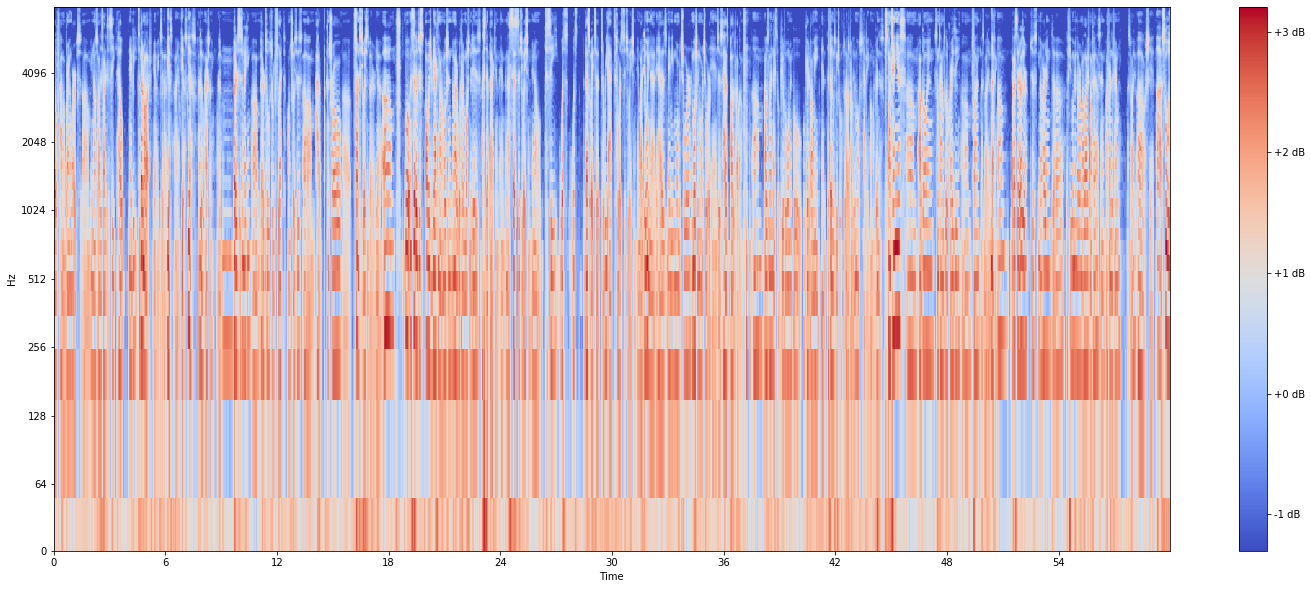

In [506]:
sp_1 = np.load('temp/DAIC_WOZ-generated_database/train/clipped_data/gender_balance/audio/mel-spectrogram/426-05_audio.npy')
plot_spectrogram(sp_1, audio_sr, HOP_SIZE, y_axis="log")

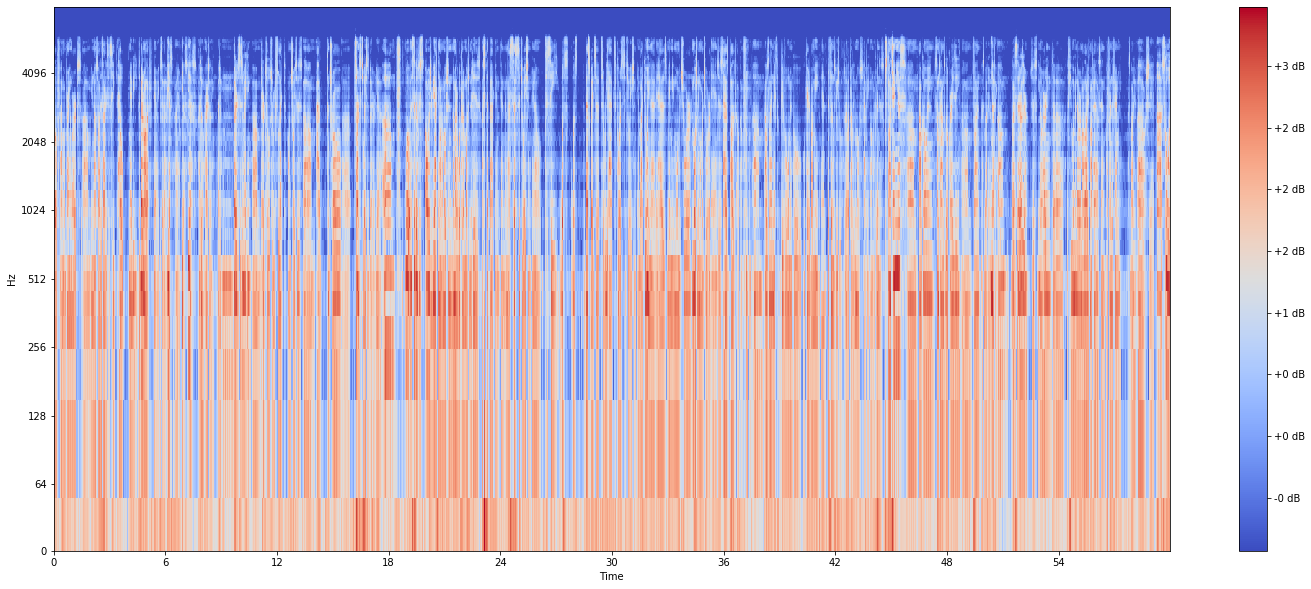

In [505]:
sp_1 = np.load('temp/DAIC_WOZ-generated_database/train/clipped_data/gender_balance/audio/mel-spectrogram/426-05_audio_trans.npy')
plot_spectrogram(sp_1, audio_sr, HOP_SIZE, y_axis="log")

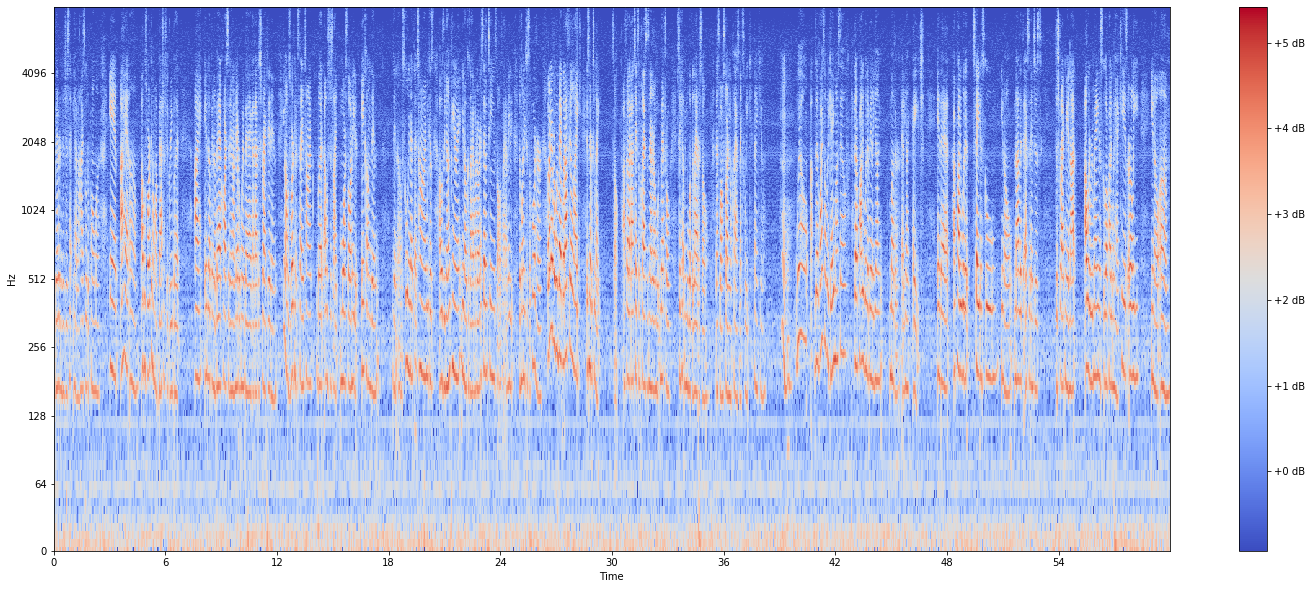

In [500]:
sp_1 = np.load('temp/DAIC_WOZ-generated_database/train/clipped_data/gender_balance/audio/spectrogram/303-06_audio.npy')
plot_spectrogram(sp_1, audio_sr, HOP_SIZE, y_axis="log")

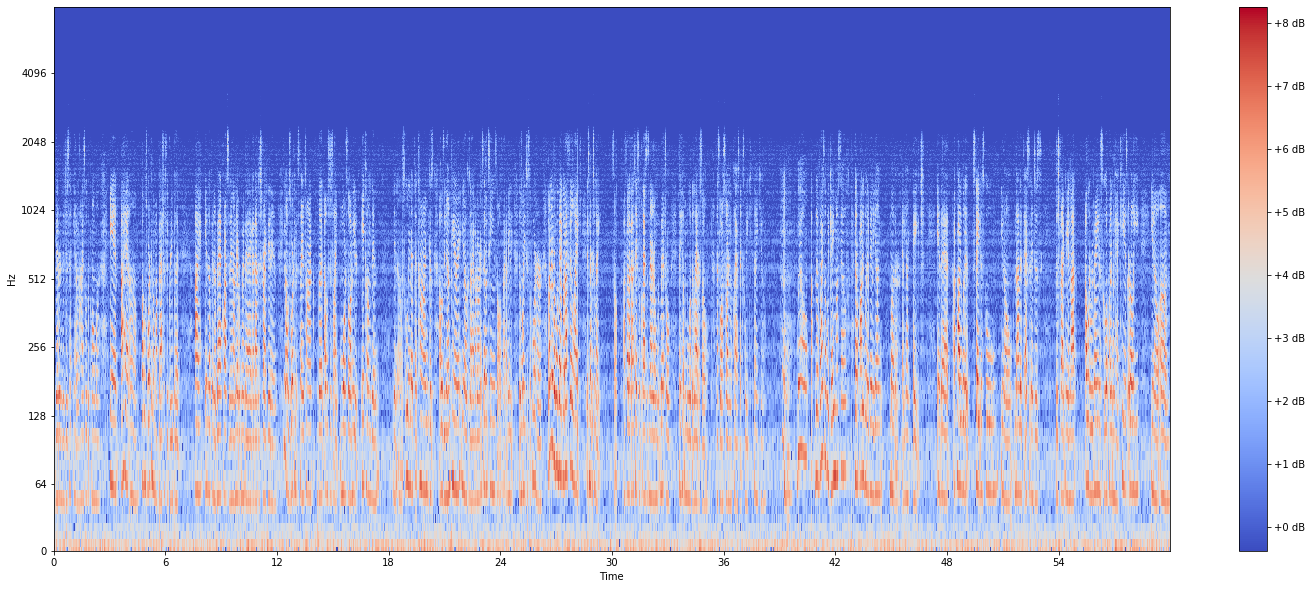

In [501]:
sp = np.load('temp/DAIC_WOZ-generated_database/train/clipped_data/gender_balance/audio/spectrogram/303-06_audio_trans.npy')
plot_spectrogram(sp, audio_sr, HOP_SIZE, y_axis="log")

In [428]:
# audio_sample = audio[int(start_time*audio_sr):int(stop_time*audio_sr)]
audio_sample = audio[int(start_time*audio_sr):int((start_time+60)*audio_sr)]
audio_sample

array([-1., -2., -3., ..., 18., 16., 15.])

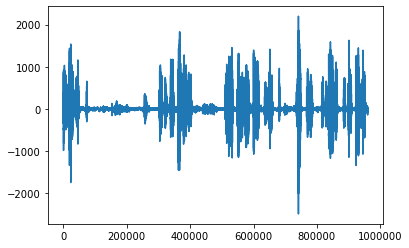

In [429]:
plt.plot(audio_sample)

Shape of the final extracted audio feature (spectra) in dB: (1025, 1802)


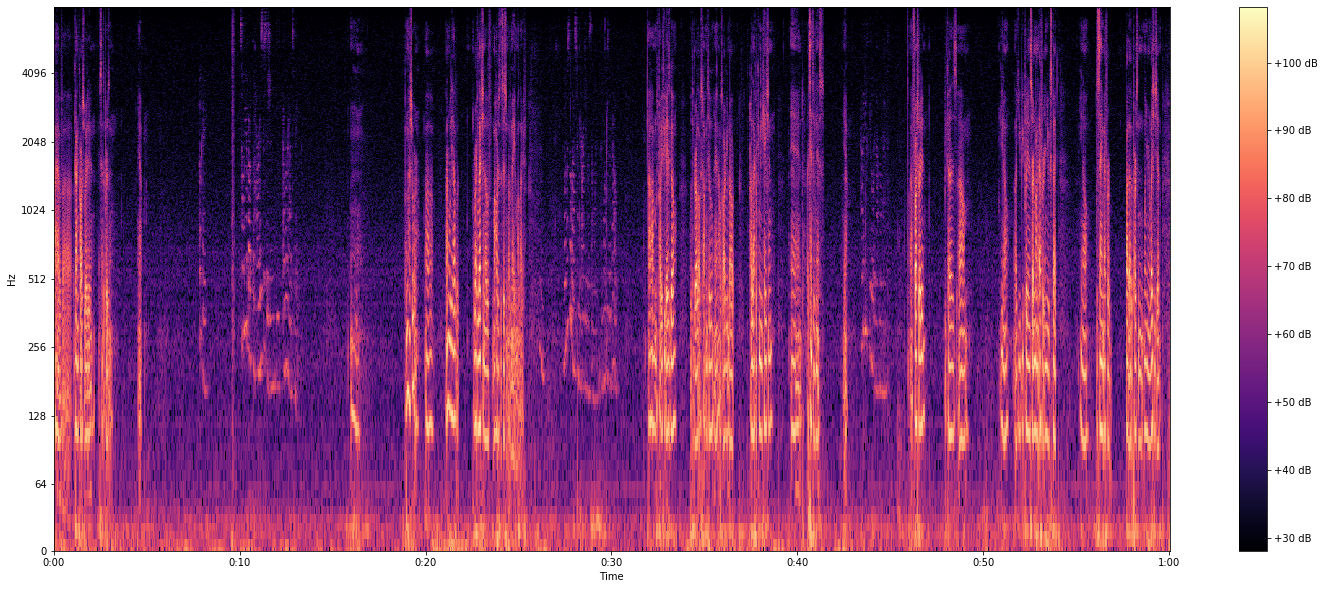

In [430]:
# spectrogram

# extracting with Short-Time Fourier Transform
FRAME_SIZE = 2048
HOP_SIZE = 533

# calculate spectrogram
S_scale = librosa.stft(audio_sample, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
Y_scale = np.abs(S_scale) ** 2

# convert amplitude to DBs
Y_log_scale = librosa.power_to_db(Y_scale)
print("Shape of the final extracted audio feature (spectra) in dB: {}".format(Y_log_scale.shape))

# plot the spectrogram, remember to set the scale of y axis also logarithmically
plot_spectrogram(Y_log_scale, audio_sr, HOP_SIZE, y_axis="log")


Shape of the final extracted audio mel feature (spectra) in dB: (80, 1802) = (number of banks, number of frames)


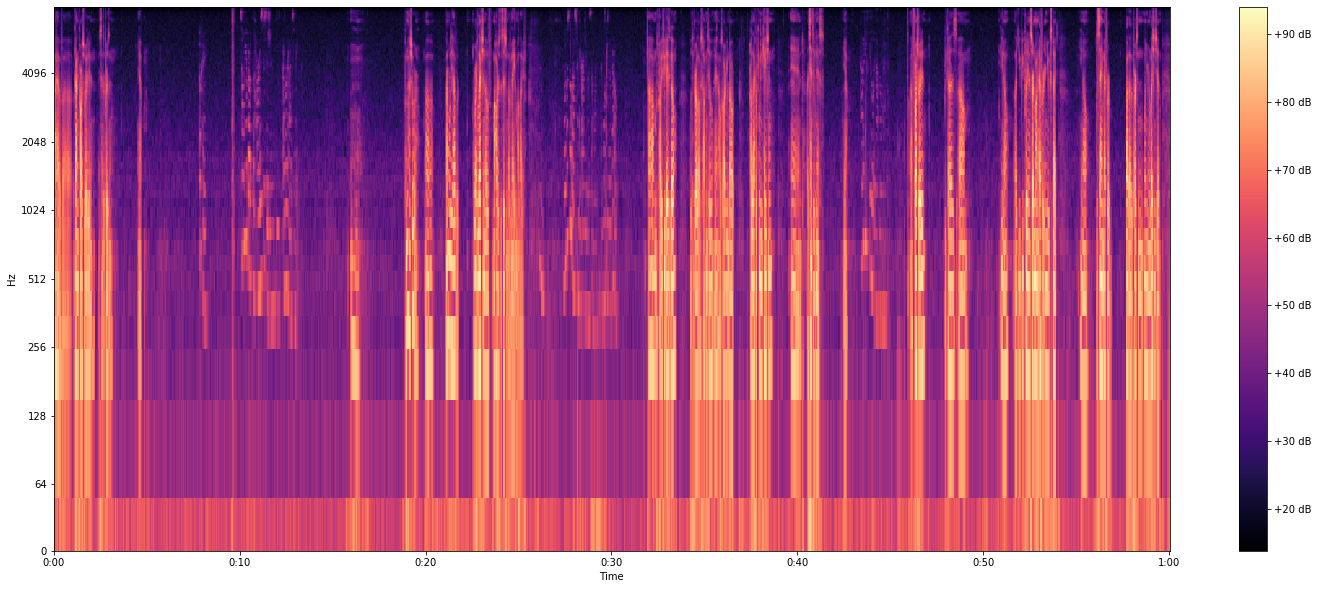

In [431]:
# Mel Spectrogram

# extracting with Short-Time Fourier Transform
frame_size = 2048
hope_size = 533
num_mel_bands = 80

# get the Mel filter banks
# filter_banks = librosa.filters.mel(n_fft=frame_size, sr=audio_sr, n_mels=num_mel_bands)

mel_spectrogram = librosa.feature.melspectrogram(audio_sample, 
                                                 sr=audio_sr, 
                                                 n_fft=frame_size, 
                                                 hop_length=hope_size, 
                                                 n_mels=num_mel_bands)

# convert amplitude to DBs
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
print("Shape of the final extracted audio mel feature (spectra) in dB: {} = (number of banks, number of frames)".format(log_mel_spectrogram.shape))

# plot the spectrogram, remember to set the scale of y axis also logarithmically
plot_spectrogram(log_mel_spectrogram, audio_sr, hope_size, y_axis="log")

## resize to see the sprectrogram diff

In [2]:
from skimage import transform

In [13]:
audio_sample = np.load('temp/304-02_audio.npy')
audio_sample.shape

(80, 1800)

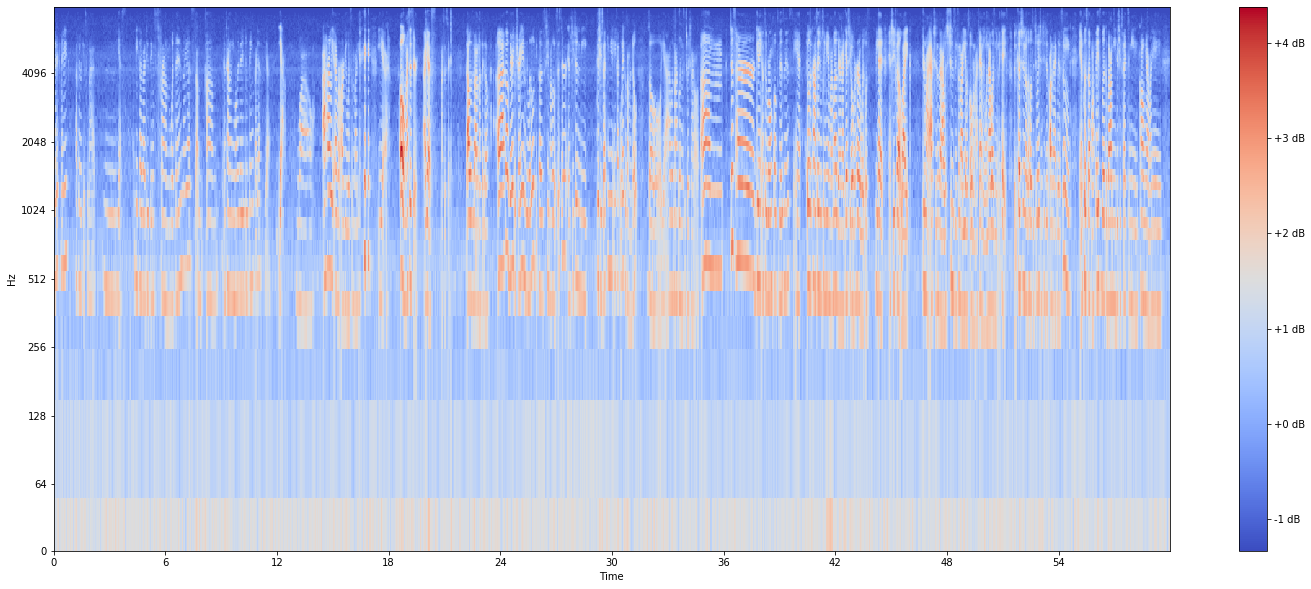

In [14]:
plot_spectrogram(audio_sample, 16000, 533, y_axis="log")

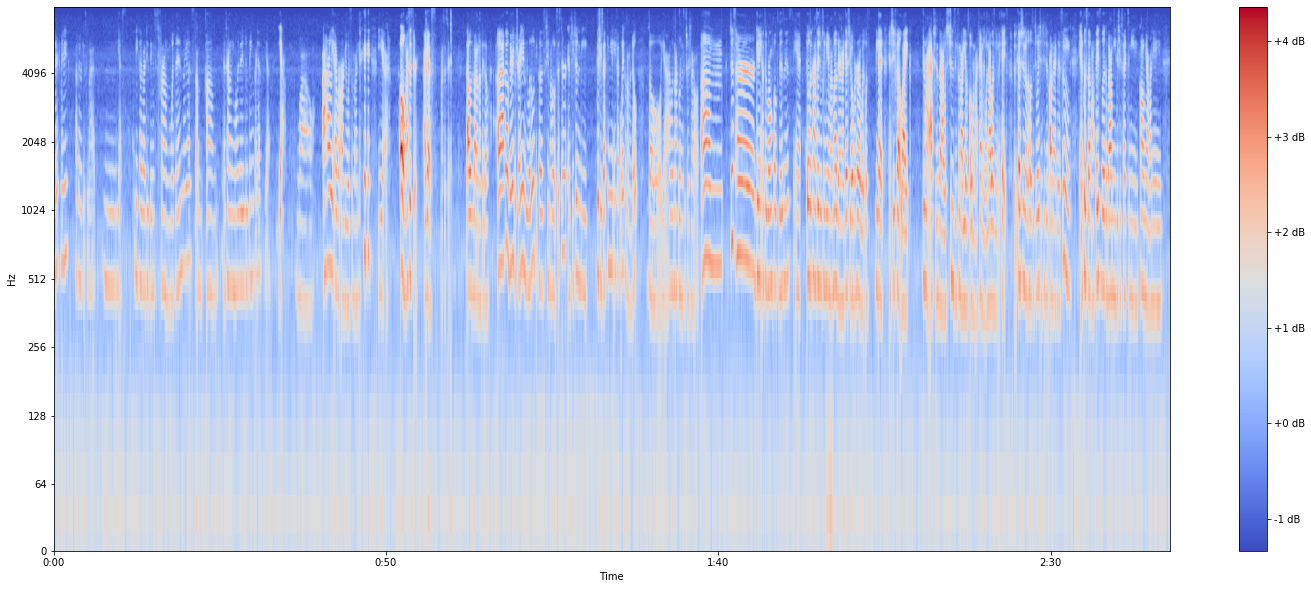

In [15]:
audio_sample = transform.resize(audio_sample, (224, 5040))
plot_spectrogram(audio_sample, 16000, 533, y_axis="log")

In [1]:
# spectrogram

# extracting with Short-Time Fourier Transform
FRAME_SIZE = 2048
HOP_SIZE = 533

# calculate spectrogram
S_scale = librosa.stft(audio_sample, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
Y_scale = np.abs(S_scale) ** 2

# convert amplitude to DBs
Y_log_scale = librosa.power_to_db(Y_scale)

h, w = Y_log_scale.shape
Y_log_scale = transform.resize(Y_log_scale, (224, 5040))
print("Shape of the final extracted audio feature (spectra) in dB: {}".format(Y_log_scale.shape))

# plot the spectrogram, remember to set the scale of y axis also logarithmically
plot_spectrogram(Y_log_scale, audio_sr, HOP_SIZE, y_axis="log")

Shape of the final extracted audio mel feature (spectra) in dB: (80, 901) = (number of banks, number of frames)


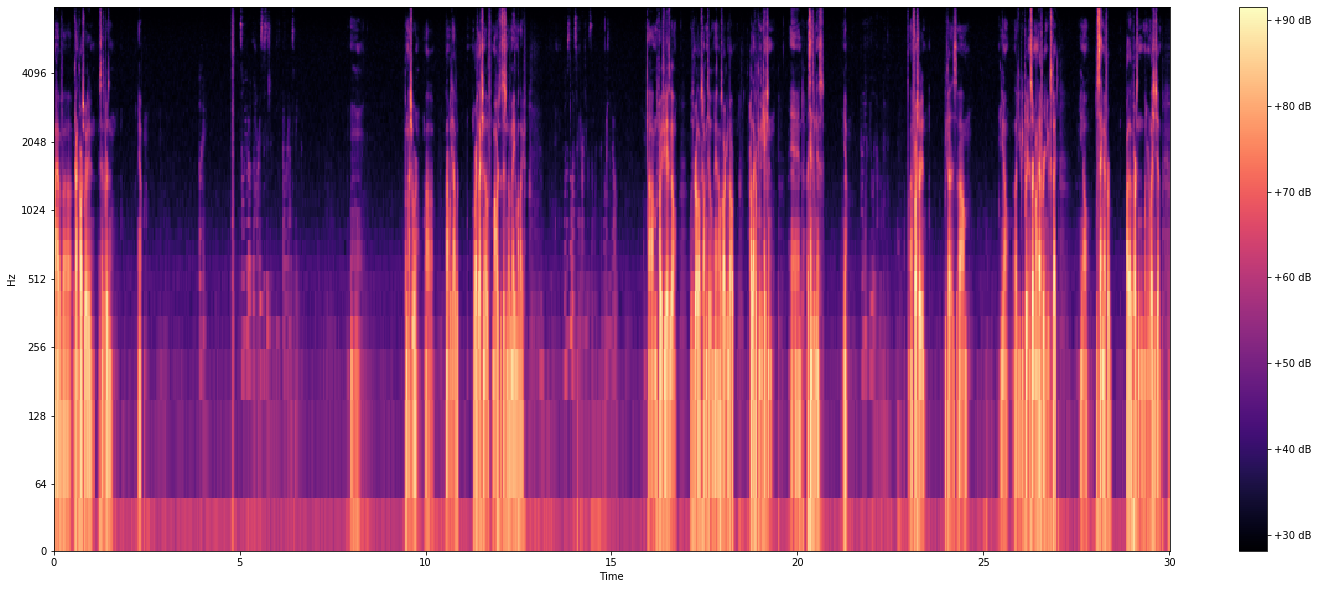

In [435]:
# Mel Spectrogram

# extracting with Short-Time Fourier Transform
frame_size = 2048
hope_size = 533
num_mel_bands = 80

# get the Mel filter banks
# filter_banks = librosa.filters.mel(n_fft=frame_size, sr=audio_sr, n_mels=num_mel_bands)

mel_spectrogram = librosa.feature.melspectrogram(audio_sample, 
                                                 sr=audio_sr, 
                                                 n_fft=frame_size, 
                                                 hop_length=hope_size, 
                                                 n_mels=num_mel_bands)

# convert amplitude to DBs
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

h, w = log_mel_spectrogram.shape
log_mel_spectrogram = transform.resize(Y_log_scale, (h, w//2))
print("Shape of the final extracted audio mel feature (spectra) in dB: {} = (number of banks, number of frames)".format(log_mel_spectrogram.shape))

# plot the spectrogram, remember to set the scale of y axis also logarithmically
plot_spectrogram(log_mel_spectrogram, audio_sr, hope_size, y_axis="log")

In [522]:
# plot facial key points to see

a = np.load('temp/DAIC_WOZ-generated_database/train/clipped_data/gender_balance/facial_keypoints/only_coordinate/303-04_kps_trans.npy')
b = np.load('temp/DAIC_WOZ-generated_database/train/clipped_data/gender_balance/facial_keypoints/only_coordinate/303-04_kps.npy')

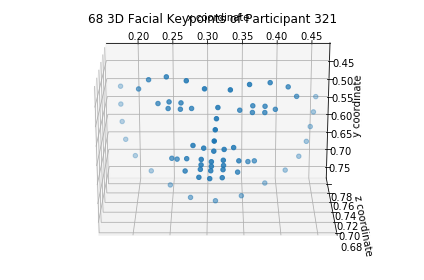

In [517]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# create GIF function    
frame = 301
# # get the first frame of facial keypoints
# x_3D = filtered_fkps_coor[frame, :,0]
# y_3D = filtered_fkps_coor[frame, :,1]
# z_3D = filtered_fkps_coor[frame, :,2]

# get the first frame of facial keypoints
x_3D = a[frame, :,0]
y_3D = a[frame, :,1]
z_3D = a[frame, :,2]

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_3D,y_3D,z_3D)


ax.view_init(elev = -70, azim = -90)
ax.set_title('68 3D Facial Keypoints of Participant 321')
#     ax.legend(loc = 'lower center')
ax.set_xlabel("x coordinate") 
ax.set_ylabel("y coordinate")
ax.set_zlabel("z coordinate")

#     ax.set_xlim([x_coor[frame_start:frame_end].min()-0.05, x_coor[frame_start:frame_end].max()+0.05])
#     ax.set_ylim([y_coor[frame_start:frame_end].min()-0.05, y_coor[frame_start:frame_end].max()+0.05])
#     ax.set_zlim([z_coor[frame_start:frame_end].min()-0.05, z_coor[frame_start:frame_end].max()+0.05])

plt.tight_layout()
# save images
#     fig.savefig(os.path.join('temp', "frame_{}.png".format(frame)))
#     plt.close()


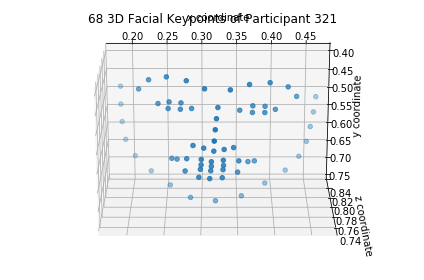

In [518]:
# get the first frame of facial keypoints
x_3D = b[frame, :, 0]
y_3D = b[frame, :, 1]
z_3D = b[frame, :, 2]

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_3D,y_3D,z_3D)

ax.view_init(elev = -70, azim = -90)
ax.set_title('68 3D Facial Keypoints of Participant 321')
ax.set_xlabel("x coordinate") 
ax.set_ylabel("y coordinate")
ax.set_zlabel("z coordinate")

plt.tight_layout()
plt.show()

# database_generation_validation.py

```
[DAIC_WOZ-generated_database]
 └── [validation]
      ├── [original_data]
      │    ├── [facial_keypoints]
      │    │    ├── [only_coordinate]
      │    │    └── [coordinate+confidence]
      │    ├── [gaze_vector]
      │    │    ├── [only_coordinate]
      │    │    └── [coordinate+confidence]
      │    ├── [audio]
      │    │    ├── [spectrogram]
      │    │    └── [Mel-spectrogram]
      │    ├── [text]
      │    │    └── [sentence_embeddings]
      │    ├── PHQ_Binary_GT.npy
      │    ├── PHQ_Score_GT.npy
      │    ├── PHQ_Subscore_GT.npy
      │    └── PHQ_Gender_GT.npy
      └── [clipped_data]
           ├── [facial_keypoints]
           │    ├── [only_coordinate]
           │    └── [coordinate+confidence]
           ├── [gaze_vector]
           │    ├── [only_coordinate]
           │    └── [coordinate+confidence]
           ├── [audio]
           │    ├── [spectrogram]
           │    └── [Mel-spectrogram]
           ├── [text]
           │    └── [sentence_embeddings]
           ├── PHQ_Binary_GT.npy
           ├── PHQ_Score_GT.npy
           ├── PHQ_Subscore_GT.npy
           └── PHQ_Gender_GT.npy        
```

In [197]:
def create_folders(root_dir):
    folders = ['original_data', 'clipped_data']
    subfolders = {'facial_keypoints': ['only_coordinate', 'coordinate+confidence'], 
                  'gaze_vectors': ['only_coordinate', 'coordinate+confidence'], 
                  'audio': ['spectrogram', 'mel-spectrogram'],
                  'text': ['sentence_embeddings']}

    os.makedirs(root_dir, exist_ok=True)
    for i in folders:
        for k, v in subfolders.items():
            for m in v:
                # print(os.path.join(root_dir, i, k, m))
                os.makedirs(os.path.join(root_dir, i, k, m), exist_ok=True)
                
                
def min_max_scaler(data):
    '''recale the data, which is a 2D matrix, to 0-1'''
    return (data - data.min())/(data.max() - data.min())


def normalize(data):
    mean = np.mean(data)
    std = np.std(data)

    return (data - mean) / std


def pre_check(data_df):
    data_df = data_df.apply(pd.to_numeric, errors='coerce')
    data_np = data_df.to_numpy()
    data_min = data_np[np.where(~(np.isnan(data_np[:, 4:])))].min()
    data_df.where(~(np.isnan(data_df)), data_min, inplace=True)
    return data_df


def load_gaze(gaze_path):
    gaze_df = pre_check(pd.read_csv(gaze_path, low_memory=False))
    # process into format TxVxC
    gaze_conf = gaze_df[' confidence'].to_numpy()
    gaze_coor = gaze_df.iloc[:, 4:].to_numpy().reshape(len(gaze_df), 4, 3)  # 4 gaze vectors, 3 axes
    T, V, C = gaze_coor.shape

    # initialize the final gaze_3D which contains coordinate and confidence score
    gaze_final = np.zeros((T, V, C+1))
    
    gaze_final[:, :, :3] = gaze_coor
    for i in range(V):
        gaze_final[:, i, 3] = gaze_conf
    
    return gaze_coor, gaze_final


def load_keypoints(keypoints_path):
    fkps_df = pre_check(pd.read_csv(keypoints_path, low_memory=False))
    # process into format TxVxC
    fkps_conf = fkps_df[' confidence'].to_numpy()
    x_coor = min_max_scaler(fkps_df[fkps_df.columns[4: 72]].to_numpy())
    y_coor = min_max_scaler(fkps_df[fkps_df.columns[72: 140]].to_numpy())
    z_coor = min_max_scaler(fkps_df[fkps_df.columns[140: 208]].to_numpy())
    fkps_coor = np.stack([x_coor, y_coor, z_coor], axis=-1)
    T, V, C = fkps_coor.shape

    # initialize the final facial key points which contains coordinate and confidence score
    fkps_final = np.zeros((T, V, C+1))

    fkps_final[:, :, :3] = fkps_coor
    for i in range(V):
        fkps_final[:, i, 3] = fkps_conf

    return fkps_coor, fkps_final


def load_audio(audio_path):
    wavefile = wave.open(audio_path)
    audio_sr = wavefile.getframerate()
    n_samples = wavefile.getnframes()
    signal = np.frombuffer(wavefile.readframes(n_samples), dtype=np.short)
    
    return signal.astype(float), audio_sr
   
    
def visual_clipping(visual_data, visual_sr, text_df):
    counter = 0
    for t in text_df.itertuples():
        if getattr(t,'speaker') == 'Participant':
            if 'scrubbed_entry' in getattr(t,'value'):
                continue
            else:
                start = getattr(t, 'start_time')
                stop = getattr(t, 'stop_time')
                start_sample = int(start * visual_sr)
                stop_sample = int(stop * visual_sr)
                if counter == 0:
                    edited_vdata = visual_data[start_sample:stop_sample]
                else:
                    edited_vdata = np.vstack((edited_vdata, visual_data[start_sample:stop_sample]))
                
                counter += 1

    return edited_vdata
    
    
def audio_clipping(audio, audio_sr, text_df, zero_padding=False):
    if zero_padding:
        edited_audio = np.zeros(audio.shape[0])
        for t in text_df.itertuples():
            if getattr(t, 'speaker') == 'Participant':
                if 'scrubbed_entry' in getattr(t,'value'):
                    continue
                else:
                    start = getattr(t, 'start_time')
                    stop = getattr(t, 'stop_time')
                    start_sample = int(start * audio_sr)
                    stop_sample = int(stop * audio_sr)
                    edited_audio[start_sample:stop_sample] = audio[start_sample:stop_sample]
        
        # cut head and tail of interview
        first_start = text_df['start_time'][0]
        last_stop = text_df['stop_time'][len(text_df)-1]
        edited_audio = edited_audio[int(first_start*audio_sr):int(last_stop*audio_sr)]
    
    else:
        edited_audio = []
        for t in text_df.itertuples():
            if getattr(t,'speaker') == 'Participant':
                if 'scrubbed_entry' in getattr(t,'value'):
                    continue
                else:
                    start = getattr(t, 'start_time')
                    stop = getattr(t, 'stop_time')
                    start_sample = int(start * audio_sr)
                    stop_sample = int(stop * audio_sr)
                    edited_audio = np.hstack((edited_audio, audio[start_sample:stop_sample]))

    return edited_audio
   
    
def convert_spectrogram(audio, frame_size=2048, hop_size=533):
    # extracting with Short-Time Fourier Transform
    S_scale = librosa.stft(audio, n_fft=frame_size, hop_length=hop_size)
    spectrogram = np.abs(S_scale) ** 2
    # convert amplitude to DBs
    log_spectrogram = librosa.power_to_db(spectrogram)
    
    return log_spectrogram  # in dB

    
def convert_mel_spectrogram(audio, audio_sr, frame_size=2048, hop_size=533, num_mel_bands=80):
    mel_spectrogram = librosa.feature.melspectrogram(audio, 
                                                     sr=audio_sr, 
                                                     n_fft=frame_size, 
                                                     hop_length=hop_size,
                                                     n_mels=num_mel_bands)
    # convert amplitude to DBs
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    return log_mel_spectrogram  # in dB


def sentence_embedding(text_df, model):
    sentences = []
    for t in text_df.itertuples():
        if getattr(t, 'speaker') == 'Participant':
            if 'scrubbed_entry' in getattr(t,'value'):
                continue
            else:
                sentences.append(getattr(t, 'value'))
    
    return model.encode(sentences)


def get_num_frame(data, frame_size, hop_size):
    T = data.shape[0]
    if (T - frame_size) % hop_size == 0:
        num_frame = (T - frame_size) // hop_size + 1
    else:
        num_frame = (T - frame_size) // hop_size + 2
    return num_frame


def get_text_hop_size(text, frame_size, num_frame):
    T = text.shape[0]
    return (T - frame_size) // (num_frame - 1)
    
    
def visual_padding(data, pad_size):
    if data.shape[0] != pad_size:
        size = tuple()
        size = size + (pad_size,) + data.shape[1:]
        padded_data = np.zeros(size)
        padded_data[:data.shape[0]] = data
    else:
        padded_data = data
    
    return padded_data


def audio_padding(data, pad_size):
    if data.shape[1] != pad_size:
        size = tuple((data.shape[0], pad_size))
        padded_data = np.zeros(size)
        padded_data[:, :data.shape[1]] = data
    else:
        padded_data = data
    
    return padded_data


def text_padding(data, pad_size):
    if data.shape[0] != pad_size:
        size = tuple((pad_size, data.shape[1]))
        padded_data = np.zeros(size)
        padded_data[:data.shape[0]] = data
    else:
        padded_data = data
    
    return padded_data


def random_shift_fkps(fkps_coor, fkps_coor_conf):
    shifted_fc = np.copy(fkps_coor)
    shifted_fcc = np.copy(fkps_coor_conf)
    
    for i in range(3):
        factor = np.random.uniform(-0.05, 0.05)
        shifted_fc[:, :, i] = shifted_fc[:, :, i] + factor
        shifted_fcc[:, :, i] = shifted_fcc[:, :, i] + factor
    
    return shifted_fc, shifted_fcc
    
    
def sliding_window(fkps_coor, fkps_coor_conf, gaze_coor, gaze_coor_conf, 
                   spectro, mel_spectro, text_feature, visual_sr, 
                   window_size, overlap_size, output_root, ID):
    
    frame_size = window_size * visual_sr
    hop_size = (window_size - overlap_size) * visual_sr
    num_frame = get_num_frame(fkps_coor, frame_size, hop_size)
    text_frame_size = 10
    text_hop_size = get_text_hop_size(text_feature, text_frame_size, num_frame)
    
    
    # start sliding through and generating data
    for i in range(num_frame):
        frame_sample_fc = visual_padding(fkps_coor[i*hop_size:i*hop_size+frame_size], frame_size)
        frame_sample_fcc = visual_padding(fkps_coor_conf[i*hop_size:i*hop_size+frame_size], frame_size)
        frame_sample_gc = visual_padding(gaze_coor[i*hop_size:i*hop_size+frame_size], frame_size)
        frame_sample_gcc = visual_padding(gaze_coor_conf[i*hop_size:i*hop_size+frame_size], frame_size)
        frame_sample_spec = audio_padding(spectro[:, i*hop_size:i*hop_size+frame_size], frame_size)
        frame_sample_mspec = audio_padding(mel_spectro[:, i*hop_size:i*hop_size+frame_size], frame_size)
        frame_sample_text = text_padding(text_feature[i*text_hop_size:i*text_hop_size+text_frame_size], text_frame_size)

        # start storing
        np.save(os.path.join(output_root, 'facial_keypoints', 'only_coordinate', f'{ID}-{i:02}_kps.npy'), frame_sample_fc)
        np.save(os.path.join(output_root, 'facial_keypoints', 'coordinate+confidence', f'{ID}-{i:02}_kps.npy'), frame_sample_fcc)
        np.save(os.path.join(output_root, 'gaze_vectors', 'only_coordinate', f'{ID}-{i:02}_gaze.npy'), frame_sample_gc)
        np.save(os.path.join(output_root, 'gaze_vectors', 'coordinate+confidence', f'{ID}-{i:02}_gaze.npy'), frame_sample_gcc)
        np.save(os.path.join(output_root, 'audio', 'spectrogram', f'{ID}-{i:02}_audio.npy'), frame_sample_spec)
        np.save(os.path.join(output_root, 'audio', 'mel-spectrogram', f'{ID}-{i:02}_audio.npy'), frame_sample_mspec)
        np.save(os.path.join(output_root, 'text', 'sentence_embeddings', f'{ID}-{i:02}_text.npy'), frame_sample_text)
        
    return num_frame


In [ ]:
# output root
root = '/cvhci/temp/wpingcheng'
root_dir = os.path.join(root, 'DAIC_WOZ-generated_database', 'validation')
create_folders(root_dir)
np.random.seed(1)

# read training gt file
gt_path = '/cvhci/temp/wpingcheng/DAIC-WOZ_dataset/dev_split_Depression_AVEC2017.csv'
gt_df = pd.read_csv(gt_path) 

# initialization
sent2vec = SentenceTransformer('all-mpnet-base-v2')
window_size = 60   # 60s
overlap_size = 10  # 10s
GT = {'original_data':
      {'ID_gt':[], 'gender_gt': [], 'phq_binary_gt': [], 'phq_score_gt':[], 'phq_subscores_gt':[]}, 
      'clipped_data':
      {'ID_gt':[], 'gender_gt': [], 'phq_binary_gt': [], 'phq_score_gt':[], 'phq_subscores_gt':[]}}

for i in range(len(gt_df)):
    # extract training gt details
    patient_ID = gt_df['Participant_ID'][i]
    phq_binary_gt = gt_df['PHQ8_Binary'][i]
    phq_score_gt = gt_df['PHQ8_Score'][i]
    gender_gt = gt_df['Gender'][i]
    phq_subscores_gt = gt_df.iloc[i, 4:].to_numpy().tolist()
    print(f'Processing Participant {patient_ID}, Gender: {gender_gt} ...')
    print(f'- PHQ Binary: {phq_binary_gt}, PHQ Score: {phq_score_gt}, Subscore: {phq_subscores_gt}')

    # get all files path of participant
    text_path = f'/cvhci/temp/wpingcheng/DAIC-WOZ_dataset/{patient_ID}_P/{patient_ID}_TRANSCRIPT.csv'
    keypoints_path = f'/cvhci/temp/wpingcheng/DAIC-WOZ_dataset/{patient_ID}_P/{patient_ID}_CLNF_features3D.txt'
    gaze_path = f'/cvhci/temp/wpingcheng/DAIC-WOZ_dataset/{patient_ID}_P/{patient_ID}_CLNF_gaze.txt'
    audio_path = f'/cvhci/temp/wpingcheng/DAIC-WOZ_dataset/{patient_ID}_P/{patient_ID}_AUDIO.wav'

    # read transcipt file
    text_df = pd.read_csv(text_path, sep='\t').fillna('')
    first_start_time = text_df['start_time'][0]
    last_stop_time = text_df['stop_time'][len(text_df)-1]

    # read & process visual files
    gaze_coor, gaze_coor_conf = load_gaze(gaze_path)
    fkps_coor, fkps_coor_conf = load_keypoints(keypoints_path)
    visual_sr = 30  # 30Hz

    # read audio file
    audio, audio_sr = load_audio(audio_path)

    # extract text feature
    text_feature = sentence_embedding(text_df, model=sent2vec)


    ########################################
    # feature extraction for original_data #
    ########################################

    print(f'Extracting feature of Participant {patient_ID} for original_data...')

    # visual
    filtered_fkps_coor = fkps_coor[int(first_start_time*visual_sr):int(last_stop_time*visual_sr)]
    filtered_fkps_coor_conf = fkps_coor_conf[int(first_start_time*visual_sr):int(last_stop_time*visual_sr)]
    filtered_gaze_coor = gaze_coor[int(first_start_time*visual_sr):int(last_stop_time*visual_sr)]
    filtered_gaze_coor_conf = gaze_coor_conf[int(first_start_time*visual_sr):int(last_stop_time*visual_sr)]

    # audio
    filtered_audio = audio_clipping(audio, audio_sr, text_df, zero_padding=True)
    # spectrogram, mel spectrogram
    spectro = normalize(convert_spectrogram(filtered_audio, frame_size=2048, hop_size=533))
    mel_spectro = normalize(convert_mel_spectrogram(filtered_audio, audio_sr, 
                                                    frame_size=2048, hop_size=533, num_mel_bands=80))


    #################################################
    # start creating data in 'original_data' folder #
    #################################################

    output_root = os.path.join(root_dir, 'original_data')
    num_frame = sliding_window(filtered_fkps_coor, filtered_fkps_coor_conf, 
                               filtered_gaze_coor, filtered_gaze_coor_conf,
                               spectro, mel_spectro, text_feature, visual_sr,
                               window_size, overlap_size, output_root, patient_ID)

    # replicate GT
    for _ in range(num_frame):
        GT['original_data']['ID_gt'].append(patient_ID)
        GT['original_data']['gender_gt'].append(gender_gt)
        GT['original_data']['phq_binary_gt'].append(phq_binary_gt)
        GT['original_data']['phq_score_gt'].append(phq_score_gt)
        GT['original_data']['phq_subscores_gt'].append(phq_subscores_gt)


    #######################################
    # feature extraction for clipped_data #
    #######################################

    print(f'Extracting feature of Participant {patient_ID} for clipped_data...')

    # visual
    clipped_fkps_coor = visual_clipping(fkps_coor, visual_sr, text_df)
    clipped_fkps_coor_conf = visual_clipping(fkps_coor_conf, visual_sr, text_df)
    clipped_gaze_coor = visual_clipping(gaze_coor, visual_sr, text_df)
    clipped_gaze_coor_conf = visual_clipping(gaze_coor_conf, visual_sr, text_df)

    # audio
    clipped_audio = audio_clipping(audio, audio_sr, text_df, zero_padding=False)
    # spectrogram, mel spectrogram
    spectro = normalize(convert_spectrogram(clipped_audio, frame_size=2048, hop_size=533))
    mel_spectro = normalize(convert_mel_spectrogram(clipped_audio, audio_sr, 
                                                    frame_size=2048, hop_size=533, num_mel_bands=80))


    ################################################
    # start creating data in 'clipped_data' folder #
    ################################################

    output_root = os.path.join(root_dir, 'clipped_data')
    num_frame = sliding_window(clipped_fkps_coor, clipped_fkps_coor_conf, 
                               clipped_gaze_coor, clipped_gaze_coor_conf,
                               spectro, mel_spectro, text_feature, visual_sr,
                               window_size, overlap_size, output_root, patient_ID)

    # replicate GT
    for _ in range(num_frame):
        GT['clipped_data']['ID_gt'].append(patient_ID)
        GT['clipped_data']['gender_gt'].append(gender_gt)
        GT['clipped_data']['phq_binary_gt'].append(phq_binary_gt)
        GT['clipped_data']['phq_score_gt'].append(phq_score_gt)
        GT['clipped_data']['phq_subscores_gt'].append(phq_subscores_gt)


# store new GT
for k1, v1 in GT.items():
    for k2, v2 in v1.items():
        # print(os.path.join(root_dir, k1, f'{k2}.npy'))
        np.save(os.path.join(root_dir, k1, f'{k2}.npy'), v2)

print('All done!')

# database_generation_test.py

In [ ]:
def create_folders(root_dir):
    folders = ['original_data', 'clipped_data']
    subfolders = {'facial_keypoints': ['only_coordinate', 'coordinate+confidence'], 
                  'gaze_vectors': ['only_coordinate', 'coordinate+confidence'], 
                  'audio': ['spectrogram', 'mel-spectrogram'],
                  'text': ['sentence_embeddings']}

    os.makedirs(root_dir, exist_ok=True)
    for i in folders:
        for k, v in subfolders.items():
            for m in v:
                # print(os.path.join(root_dir, i, k, m))
                os.makedirs(os.path.join(root_dir, i, k, m), exist_ok=True)
                
                
def min_max_scaler(data):
    '''recale the data, which is a 2D matrix, to 0-1'''
    return (data - data.min())/(data.max() - data.min())

def normalize(data):
    mean = np.mean(data)
    std = np.std(data)

    return (data - mean) / std

def load_gaze(gaze_path):
    gaze_df = pd.read_csv(gaze_path)
    # process into format TxVxC
    gaze_conf = gaze_df[' confidence'].to_numpy()
    gaze_coor = gaze_df.iloc[:, 4:].to_numpy().reshape(len(gaze_df), 4, 3)  # 4 gaze vectors, 3 axes
    T, V, C = gaze_coor.shape

    # initialize the final gaze_3D which contains coordinate and confidence score
    gaze_final = np.zeros((T, V, C+1))
    
    gaze_final[:, :, :3] = gaze_coor
    for i in range(V):
        gaze_final[:, i, 3] = gaze_conf
    
    return gaze_coor, gaze_final


def load_keypoints(keypoints_path):
    fkps_df = pd.read_csv(keypoints_path)
    # process into format TxVxC
    fkps_conf = fkps_df[' confidence'].to_numpy()
    x_coor = min_max_scaler(fkps_df[fkps_df.columns[4: 72]].to_numpy())
    y_coor = min_max_scaler(fkps_df[fkps_df.columns[72: 140]].to_numpy())
    z_coor = min_max_scaler(fkps_df[fkps_df.columns[140: 208]].to_numpy())
    fkps_coor = np.stack([x_coor, y_coor, z_coor], axis=-1)
    T, V, C = fkps_coor.shape

    # initialize the final facial key points which contains coordinate and confidence score
    fkps_final = np.zeros((T, V, C+1))

    fkps_final[:, :, :3] = fkps_coor
    for i in range(V):
        fkps_final[:, i, 3] = fkps_conf

    return fkps_coor, fkps_final


def load_audio(audio_path):
    wavefile = wave.open(audio_path)
    audio_sr = wavefile.getframerate()
    n_samples = wavefile.getnframes()
    signal = np.frombuffer(wavefile.readframes(n_samples), dtype=np.short)
    
    return signal.astype(float), audio_sr
   
    
def visual_clipping(visual_data, visual_sr, text_df):
    counter = 0
    for t in text_df.itertuples():
        if getattr(t,'speaker') == 'Participant':
            if 'scrubbed_entry' in getattr(t,'value'):
                continue
            else:
                start = getattr(t, 'start_time')
                stop = getattr(t, 'stop_time')
                start_sample = int(start * visual_sr)
                stop_sample = int(stop * visual_sr)
                if counter == 0:
                    edited_vdata = visual_data[start_sample:stop_sample]
                else:
                    edited_vdata = np.vstack((edited_vdata, visual_data[start_sample:stop_sample]))
                
                counter += 1

    return edited_vdata
    
    
def audio_clipping(audio, audio_sr, text_df, zero_padding=False):
    if zero_padding:
        edited_audio = np.zeros(audio.shape[0])
        for t in text_df.itertuples():
            if getattr(t, 'speaker') == 'Participant':
                if 'scrubbed_entry' in getattr(t,'value'):
                    continue
                else:
                    start = getattr(t, 'start_time')
                    stop = getattr(t, 'stop_time')
                    start_sample = int(start * audio_sr)
                    stop_sample = int(stop * audio_sr)
                    edited_audio[start_sample:stop_sample] = audio[start_sample:stop_sample]
        
        # cut head and tail of interview
        first_start = text_df['start_time'][0]
        last_stop = text_df['stop_time'][len(text_df)-1]
        edited_audio = edited_audio[int(first_start*audio_sr):int(last_stop*audio_sr)]
    
    else:
        edited_audio = []
        for t in text_df.itertuples():
            if getattr(t,'speaker') == 'Participant':
                if 'scrubbed_entry' in getattr(t,'value'):
                    continue
                else:
                    start = getattr(t, 'start_time')
                    stop = getattr(t, 'stop_time')
                    start_sample = int(start * audio_sr)
                    stop_sample = int(stop * audio_sr)
                    edited_audio = np.hstack((edited_audio, audio[start_sample:stop_sample]))

    return edited_audio
   
    
def convert_spectrogram(audio, frame_size=2048, hop_size=533):
    # extracting with Short-Time Fourier Transform
    S_scale = librosa.stft(audio, n_fft=frame_size, hop_length=hop_size)
    spectrogram = np.abs(S_scale) ** 2
    # convert amplitude to DBs
    log_spectrogram = librosa.power_to_db(spectrogram)
    
    return log_spectrogram  # in dB

    
def convert_mel_spectrogram(audio, audio_sr, frame_size=2048, hop_size=533, num_mel_bands=80):
    mel_spectrogram = librosa.feature.melspectrogram(audio, 
                                                     sr=audio_sr, 
                                                     n_fft=frame_size, 
                                                     hop_length=hop_size,
                                                     n_mels=num_mel_bands)
    # convert amplitude to DBs
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    return log_mel_spectrogram  # in dB


def sentence_embedding(text_df, model):
    sentences = []
    for t in text_df.itertuples():
        if getattr(t, 'speaker') == 'Participant':
            if 'scrubbed_entry' in getattr(t,'value'):
                continue
            else:
                sentences.append(getattr(t, 'value'))
    
    return model.encode(sentences)


def get_num_frame(data, frame_size, hop_size):
    T = data.shape[0]
    if (T - frame_size) % hop_size == 0:
        num_frame = (T - frame_size) // hop_size + 1
    else:
        num_frame = (T - frame_size) // hop_size + 2
    return num_frame


def get_text_hop_size(text, frame_size, num_frame):
    T = text.shape[0]
    return (T - frame_size) // (num_frame - 1)
    
    
def visual_padding(data, pad_size):
    if data.shape[0] != pad_size:
        size = tuple()
        size = size + (pad_size,) + data.shape[1:]
        padded_data = np.zeros(size)
        padded_data[:data.shape[0]] = data
    else:
        padded_data = data
    
    return padded_data


def audio_padding(data, pad_size):
    if data.shape[1] != pad_size:
        size = tuple((data.shape[0], pad_size))
        padded_data = np.zeros(size)
        padded_data[:, :data.shape[1]] = data
    else:
        padded_data = data
    
    return padded_data


def text_padding(data, pad_size):
    if data.shape[0] != pad_size:
        size = tuple((pad_size, data.shape[1]))
        padded_data = np.zeros(size)
        padded_data[:data.shape[0]] = data
    else:
        padded_data = data
    
    return padded_data


def random_shift_fkps(fkps_coor, fkps_coor_conf):
    shifted_fc = np.copy(fkps_coor)
    shifted_fcc = np.copy(fkps_coor_conf)
    
    for i in range(3):
        factor = np.random.uniform(-0.05, 0.05)
        shifted_fc[:, :, i] = shifted_fc[:, :, i] + factor
        shifted_fcc[:, :, i] = shifted_fcc[:, :, i] + factor
    
    return shifted_fc, shifted_fcc
    
    
def sliding_window(fkps_coor, fkps_coor_conf, gaze_coor, gaze_coor_conf, 
                   spectro, mel_spectro, text_feature, visual_sr, 
                   window_size, overlap_size, output_root, ID):
    
    frame_size = window_size * visual_sr
    hop_size = (window_size - overlap_size) * visual_sr
    num_frame = get_num_frame(fkps_coor, frame_size, hop_size)
    text_frame_size = 10
    text_hop_size = get_text_hop_size(text_feature, text_frame_size, num_frame)
    
    
    # start sliding through and generating data
    for i in range(num_frame):
        frame_sample_fc = visual_padding(fkps_coor[i*hop_size:i*hop_size+frame_size], frame_size)
        frame_sample_fcc = visual_padding(fkps_coor_conf[i*hop_size:i*hop_size+frame_size], frame_size)
        frame_sample_gc = visual_padding(gaze_coor[i*hop_size:i*hop_size+frame_size], frame_size)
        frame_sample_gcc = visual_padding(gaze_coor_conf[i*hop_size:i*hop_size+frame_size], frame_size)
        frame_sample_spec = audio_padding(spectro[:, i*hop_size:i*hop_size+frame_size], frame_size)
        frame_sample_mspec = audio_padding(mel_spectro[:, i*hop_size:i*hop_size+frame_size], frame_size)
        frame_sample_text = text_padding(text_feature[i*text_hop_size:i*text_hop_size+text_frame_size], text_frame_size)

        # start storing
        np.save(os.path.join(output_root, 'facial_keypoints', 'only_coordinate', f'{ID}-{i:02}_kps.npy'), frame_sample_fc)
        np.save(os.path.join(output_root, 'facial_keypoints', 'coordinate+confidence', f'{ID}-{i:02}_kps.npy'), frame_sample_fcc)
        np.save(os.path.join(output_root, 'gaze_vectors', 'only_coordinate', f'{ID}-{i:02}_gaze.npy'), frame_sample_gc)
        np.save(os.path.join(output_root, 'gaze_vectors', 'coordinate+confidence', f'{ID}-{i:02}_gaze.npy'), frame_sample_gcc)
        np.save(os.path.join(output_root, 'audio', 'spectrogram', f'{ID}-{i:02}_audio.npy'), frame_sample_spec)
        np.save(os.path.join(output_root, 'audio', 'mel-spectrogram', f'{ID}-{i:02}_audio.npy'), frame_sample_mspec)
        np.save(os.path.join(output_root, 'text', 'sentence_embeddings', f'{ID}-{i:02}_text.npy'), frame_sample_text)
        
    return num_frame


In [ ]:
# output root
root = '/cvhci/temp/wpingcheng'
root_dir = os.path.join(root, 'DAIC_WOZ-generated_database', 'test')
create_folders(root_dir)
np.random.seed(1)

# read training gt file
gt_path = '/cvhci/temp/wpingcheng/DAIC-WOZ_dataset/full_test_split.csv'
gt_df = pd.read_csv(gt_path)

# initialization
sent2vec = SentenceTransformer('all-mpnet-base-v2')
window_size = 60   # 60s
overlap_size = 10  # 10s
GT = {'original_data':
      {'ID_gt':[], 'gender_gt': [], 'phq_binary_gt': [], 'phq_score_gt':[], 'phq_subscores_gt':[]}, 
      'clipped_data':
      {'ID_gt':[], 'gender_gt': [], 'phq_binary_gt': [], 'phq_score_gt':[], 'phq_subscores_gt':[]}}

for i in range(len(gt_df)):
    # extract training gt details
    patient_ID = gt_df['Participant_ID'][i]
    phq_binary_gt = gt_df['PHQ_Binary'][i]
    phq_score_gt = gt_df['PHQ_Score'][i]
    gender_gt = gt_df['Gender'][i]
    phq_subscores_gt = None
    print(f'Processing Participant {patient_ID}, Gender: {gender_gt} ...')
    print(f'- PHQ Binary: {phq_binary_gt}, PHQ Score: {phq_score_gt}, Subscore: {phq_subscores_gt}')

    # get all files path of participant
    text_path = f'/cvhci/temp/wpingcheng/DAIC-WOZ_dataset/{patient_ID}_P/{patient_ID}_TRANSCRIPT.csv'
    keypoints_path = f'/cvhci/temp/wpingcheng/DAIC-WOZ_dataset/{patient_ID}_P/{patient_ID}_CLNF_features3D.txt'
    gaze_path = f'/cvhci/temp/wpingcheng/DAIC-WOZ_dataset/{patient_ID}_P/{patient_ID}_CLNF_gaze.txt'
    audio_path = f'/cvhci/temp/wpingcheng/DAIC-WOZ_dataset/{patient_ID}_P/{patient_ID}_AUDIO.wav'

    # read transcipt file
    text_df = pd.read_csv(text_path, sep='\t').fillna('')
    first_start_time = text_df['start_time'][0]
    last_stop_time = text_df['stop_time'][len(text_df)-1]

    # read & process visual files
    gaze_coor, gaze_coor_conf = load_gaze(gaze_path)
    fkps_coor, fkps_coor_conf = load_keypoints(keypoints_path)
    visual_sr = 30  # 30Hz

    # read audio file
    audio, audio_sr = load_audio(audio_path)

    # extract text feature
    text_feature = sentence_embedding(text_df, model=sent2vec)


    ########################################
    # feature extraction for original_data #
    ########################################

    print(f'Extracting feature of Participant {patient_ID} for original_data...')

    # visual
    filtered_fkps_coor = fkps_coor[int(first_start_time*visual_sr):int(last_stop_time*visual_sr)]
    filtered_fkps_coor_conf = fkps_coor_conf[int(first_start_time*visual_sr):int(last_stop_time*visual_sr)]
    filtered_gaze_coor = gaze_coor[int(first_start_time*visual_sr):int(last_stop_time*visual_sr)]
    filtered_gaze_coor_conf = gaze_coor_conf[int(first_start_time*visual_sr):int(last_stop_time*visual_sr)]

    # audio
    filtered_audio = audio_clipping(audio, audio_sr, text_df, zero_padding=True)
    # spectrogram, mel spectrogram
    spectro = normalize(convert_spectrogram(filtered_audio, frame_size=2048, hop_size=533))
    mel_spectro = normalize(convert_mel_spectrogram(filtered_audio, audio_sr, 
                                                    frame_size=2048, hop_size=533, num_mel_bands=80))


    #################################################
    # start creating data in 'original_data' folder #
    #################################################

    output_root = os.path.join(root_dir, 'original_data')
    num_frame = sliding_window(filtered_fkps_coor, filtered_fkps_coor_conf, 
                               filtered_gaze_coor, filtered_gaze_coor_conf,
                               spectro, mel_spectro, text_feature, visual_sr,
                               window_size, overlap_size, output_root, patient_ID)

    # replicate GT
    for _ in range(num_frame):
        GT['original_data']['ID_gt'].append(patient_ID)
        GT['original_data']['gender_gt'].append(gender_gt)
        GT['original_data']['phq_binary_gt'].append(phq_binary_gt)
        GT['original_data']['phq_score_gt'].append(phq_score_gt)
        GT['original_data']['phq_subscores_gt'].append(phq_subscores_gt)


    #######################################
    # feature extraction for clipped_data #
    #######################################

    print(f'Extracting feature of Participant {patient_ID} for clipped_data...')

    # visual
    clipped_fkps_coor = visual_clipping(fkps_coor, visual_sr, text_df)
    clipped_fkps_coor_conf = visual_clipping(fkps_coor_conf, visual_sr, text_df)
    clipped_gaze_coor = visual_clipping(gaze_coor, visual_sr, text_df)
    clipped_gaze_coor_conf = visual_clipping(gaze_coor_conf, visual_sr, text_df)

    # audio
    clipped_audio = audio_clipping(audio, audio_sr, text_df, zero_padding=False)
    # spectrogram, mel spectrogram
    spectro = normalize(convert_spectrogram(clipped_audio, frame_size=2048, hop_size=533))
    mel_spectro = normalize(convert_mel_spectrogram(clipped_audio, audio_sr, 
                                                    frame_size=2048, hop_size=533, num_mel_bands=80))


    ################################################
    # start creating data in 'clipped_data' folder #
    ################################################

    output_root = os.path.join(root_dir, 'clipped_data')
    num_frame = sliding_window(clipped_fkps_coor, clipped_fkps_coor_conf, 
                               clipped_gaze_coor, clipped_gaze_coor_conf,
                               spectro, mel_spectro, text_feature, visual_sr,
                               window_size, overlap_size, output_root, patient_ID)

    # replicate GT
    for _ in range(num_frame):
        GT['clipped_data']['ID_gt'].append(patient_ID)
        GT['clipped_data']['gender_gt'].append(gender_gt)
        GT['clipped_data']['phq_binary_gt'].append(phq_binary_gt)
        GT['clipped_data']['phq_score_gt'].append(phq_score_gt)
        GT['clipped_data']['phq_subscores_gt'].append(phq_subscores_gt)


# store new GT
for k1, v1 in GT.items():
    for k2, v2 in v1.items():
        # print(os.path.join(root_dir, k1, f'{k2}.npy'))
        np.save(os.path.join(root_dir, k1, f'{k2}.npy'), v2)

print('All done!')